In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
#sys.path.insert(0, '/Users/kvolk/Documents/GitHub/SBDynT/src')
sys.path.insert(0, '../src')
import run_reb
import rebound
import numpy as np
import horizons_api
import tools
from bin_to_df import bin_to_df

import scipy.signal as signal


%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["figure.titlesize"] = 25

# First, an example of filtering an idealized signal

calculate and plot FFT power spectrum and lombscargle power spectrum

Do a really simple filtering procedure to zero out the "planet" frequencies

# Working with actual data

read in data for a classical belt object I'm sure isn't in or super close to a  mean motion resonance

In [3]:
#(keep the space in sbody, it's a typo from when I ran it, but the hash has the space)\
#this will take a while, it's a 100 Myr integration with a 500 year output cadence
sbody = '2004PY107'
objname = '2004 PY107'

#sbody = '2004KF19'
#objname = '2004KF19'
#path = 'Asteroids/'+objname
#path = 'TNOs/'+objname
sbody = '22'
objname = '22'

#sbody = '2004KF19'
#objname = '2004KF19'
dt=500.
path = 'Sims/AstFam/'+objname
#path = 'TNOs/'+objname

#these arrays are all a bit of a mess, at some point would want to 
#change it to be a multi-dimensional array for the planets so they 
#don't all have to be handled by hand
a = np.zeros(1);e = np.zeros(1);inc = np.zeros(1);
p = np.zeros(1);q = np.zeros(1);h = np.zeros(1);k = np.zeros(1);
pu = np.zeros(1);qu = np.zeros(1);hu = np.zeros(1);ku = np.zeros(1);
pj = np.zeros(1);qj = np.zeros(1);hj = np.zeros(1);kj = np.zeros(1);
ps = np.zeros(1);qs = np.zeros(1);hs = np.zeros(1);ks = np.zeros(1);
pn = np.zeros(1);qn = np.zeros(1);hn = np.zeros(1);kn = np.zeros(1);
omega = np.zeros(1);
Omega = np.zeros(1);
M = np.zeros(1)
t = np.zeros(1);
fullfile = 'Sims/AstFam/22/archive.bin'
print(fullfile)
arc1 = rebound.SimulationArchive(fullfile)
series = bin_to_df('AstFam','22',arc1,'8planet')
#series = pd.read_csv(path+'/series.csv')
t = series['t'].values
dt=int(t[1])/20
a = series['a'].values
e = series['ecc'].values
inc = series['inc'].values
#omega = series['omega'].values
#Omega = series['Omega'].values
#M = series['M'].values
h = series['h'].values
k = series['k'].values
p = series['p'].values
q = series['q'].values

hj = series['hj'].values
kj = series['kj'].values
pj = series['pj'].values
qj = series['qj'].values

hs = series['hs'].values
ks = series['ks'].values
ps = series['ps'].values
qs = series['qs'].values

hu = series['hu'].values
ku = series['ku'].values
pu = series['pu'].values
qu = series['qu'].values

hn = series['hn'].values
kn = series['kn'].values
pn = series['pn'].values
qn = series['qn'].values

hmr = series['hmr'].values
kmr = series['kmr'].values
pmr = series['pmr'].values
qmr = series['qmr'].values

hv = series['hv'].values
kv = series['kv'].values
pv = series['pv'].values
qv = series['qv'].values

he = series['he'].values
ke = series['ke'].values
pe = series['pe'].values
qe = series['qe'].values

hmc = series['hmc'].values
kmc = series['kmc'].values
pmc = series['pmc'].values
qmc = series['qmc'].values

Sims/AstFam/22/archive.bin


/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [14]:
sbody = '2004PY107'
objname = '2004 PY107'

#sbody = '2004KF19'
#objname = '2004KF19'
#path = 'Asteroids/'+objname
path = 'TNOs/'+objname

archive = rebound.SimulationArchive(path+'/archive.bin')
series = bin_to_df.bin_to_df(objname,archive)

t = series['t'].values
a = series['a'].values
e = series['ecc'].values
inc = series['inc'].values

h = series['h'].values
k = series['k'].values
p = series['p'].values
q = series['q'].values

hj = series['hj'].values
kj = series['kj'].values
pj = series['pj'].values
qj = series['qj'].values

hs = series['hs'].values
ks = series['ks'].values
ps = series['ps'].values
qs = series['qs'].values

hn = series['hn'].values
kn = series['kn'].values
pn = series['pn'].values
qn = series['qn'].values

hmr = series['hmr'].values
kmr = series['kmr'].values
pmr = series['pmr'].values
qmr = series['qmr'].values

hv = series['hv'].values
kv = series['kv'].values
pv = series['pv'].values
qv = series['qv'].values

he = series['he'].values
ke = series['ke'].values
pe = series['pe'].values
qe = series['qe'].values

hmc = series['hmc'].values
kmc = series['kmc'].values
pmc = series['pmc'].values
qmc = series['qmc'].values

hu = series['hu'].values
ku = series['ku'].values
pu = series['pu'].values
qu = series['qu'].values

RuntimeError: Cannot read binary file. Check filename and file contents.

In [4]:
print(t)

[0.00000000e+00 1.00008000e+02 2.00004000e+02 ... 9.99800003e+05
 9.99900011e+05 1.00000000e+06]


do all the FFTs for the inclination and eccentricity vectors

In [9]:
#set up all the FFT power spectra, etc
#the outputs are not exact, but it's about 
dt = 1000
n = len(h)
freq = np.fft.rfftfreq(n,d=dt)

#particle eccentricity vectors
Yh= np.fft.rfft(h)
Yk = np.fft.rfft(k)
#giant planets
Yhmc = np.fft.rfft(hmc)
Yhv = np.fft.rfft(hv)
Yhe = np.fft.rfft(he)
Yhmr = np.fft.rfft(hmr)
Ykmc = np.fft.rfft(kmc)
Ykv = np.fft.rfft(kv)
Yke = np.fft.rfft(ke)
Ykmr = np.fft.rfft(kmr)
Yhu = np.fft.rfft(hu)
Yhj = np.fft.rfft(hj)
Yhn = np.fft.rfft(hn)
Yhs = np.fft.rfft(hs)
Yku = np.fft.rfft(ku)
Ykj = np.fft.rfft(kj)
Ykn = np.fft.rfft(kn)
Yks = np.fft.rfft(ks)

#convert to power
pYh = np.abs(Yh)
pYk = np.abs(Yk)

pYhmc = np.abs(Yhmc)
pYhv = np.abs(Yhv)
pYhe = np.abs(Yhe)
pYhmr = np.abs(Yhmr)
pYkmc = np.abs(Ykmc)
pYkmr = np.abs(Ykmr)
pYkv = np.abs(Ykv)
pYke = np.abs(Yke)

pYhu = np.abs(Yhu)
pYhn = np.abs(Yhn)
pYhj = np.abs(Yhj)
pYhs = np.abs(Yhs)
pYku = np.abs(Yku)
pYkn = np.abs(Ykn)
pYkj = np.abs(Ykj)
pYks = np.abs(Yks)


#find the max power and indexes of that max power
#(disregarding the frequency=0 terms)
kumax = pYku[1:].max()
knmax = pYkn[1:].max()
ksmax = pYks[1:].max()
kjmax = pYkj[1:].max()
humax = pYhu[1:].max()
hnmax = pYhn[1:].max()
hsmax = pYhs[1:].max()
hjmax = pYhj[1:].max()

kmcmax = pYkmc[1:].max()
kmrmax = pYkmr[1:].max()
kvmax = pYkv[1:].max()
kemax = pYke[1:].max()
hmcmax = pYhmc[1:].max()
hmrmax = pYhmr[1:].max()
hvmax = pYhv[1:].max()
hemax = pYhe[1:].max()

#(these need the plus 1 to account for neglecting the f=0 term)
ihmax = np.argmax(pYh[1:])+1
ikmax = np.argmax(pYk[1:])+1
ihumax = np.argmax(pYhu[1:])+1
ihnmax = np.argmax(pYhn[1:])+1 
ihsmax = np.argmax(pYhs[1:])+1 
ihjmax = np.argmax(pYhj[1:])+1 
ikumax = np.argmax(pYku[1:])+1 
iknmax = np.argmax(pYkn[1:])+1
iksmax = np.argmax(pYks[1:])+1
ikjmax = np.argmax(pYkj[1:])+1 

ihmcmax = np.argmax(pYhmc[1:])+1
ihmrmax = np.argmax(pYhmr[1:])+1 
ihvmax = np.argmax(pYhv[1:])+1 
ihemax = np.argmax(pYhe[1:])+1 
ikmcmax = np.argmax(pYkmc[1:])+1 
ikmrmax = np.argmax(pYkmr[1:])+1
ikvmax = np.argmax(pYkv[1:])+1
ikemax = np.argmax(pYke[1:])+1 


#particle inclination vectors
Yp= np.fft.rfft(p)
Yq = np.fft.rfft(q)
#giant planets
Ypu = np.fft.rfft(pu)
Ypj = np.fft.rfft(pj)
Ypn = np.fft.rfft(pn)
Yps = np.fft.rfft(ps)
Yqu = np.fft.rfft(qu)
Yqj = np.fft.rfft(qj)
Yqn = np.fft.rfft(qn)
Yqs = np.fft.rfft(qs)

Ypmc = np.fft.rfft(pmc)
Ypmr = np.fft.rfft(pmr)
Ypv = np.fft.rfft(pv)
Ype = np.fft.rfft(pe)
Yqmc = np.fft.rfft(qmc)
Yqmr = np.fft.rfft(qmr)
Yqv = np.fft.rfft(qv)
Yqe = np.fft.rfft(qe)

#convert to power
pYp = np.abs(Yp)
pYq = np.abs(Yq)
pYpu = np.abs(Ypu)
pYpn = np.abs(Ypn)
pYpj = np.abs(Ypj)
pYps = np.abs(Yps)
pYqu = np.abs(Yqu)
pYqn = np.abs(Yqn)
pYqj = np.abs(Yqj)
pYqs = np.abs(Yqs)

pYpmc = np.abs(Ypmc)
pYpmr = np.abs(Ypmr)
pYpv = np.abs(Ypv)
pYpe = np.abs(Ype)
pYqmc = np.abs(Yqmc)
pYqmr = np.abs(Yqmr)
pYqv = np.abs(Yqv)
pYqe = np.abs(Yqe)


#find the max power and indexes of that max power
#(disregarding the frequency=0 terms)
pumax = pYpu[1:].max()
pnmax = pYpn[1:].max()
psmax = pYps[1:].max()
pjmax = pYpj[1:].max()
qumax = pYqu[1:].max()
qnmax = pYqn[1:].max()
qsmax = pYqs[1:].max()
qjmax = pYqj[1:].max()

pmcmax = pYpmc[1:].max()
pmrmax = pYpmr[1:].max()
pvmax = pYpv[1:].max()
pemax = pYpe[1:].max()
qmcmax = pYqmc[1:].max()
qmrmax = pYqmr[1:].max()
qvmax = pYqv[1:].max()
qemax = pYqe[1:].max()

ipmax = np.argmax(pYp[1:])+1
iqmax = np.argmax(pYq[1:])+1
ipumax = np.argmax(pYpu[1:])+1
ipnmax = np.argmax(pYpn[1:])+1 
ipsmax = np.argmax(pYps[1:])+1 
ipjmax = np.argmax(pYpj[1:])+1 
iqumax = np.argmax(pYqu[1:])+1 
iqnmax = np.argmax(pYqn[1:])+1
iqsmax = np.argmax(pYqs[1:])+1
iqjmax = np.argmax(pYqj[1:])+1 

ipmcmax = np.argmax(pYpmc[1:])+1
ipmrmax = np.argmax(pYpmr[1:])+1 
ipvmax = np.argmax(pYpv[1:])+1 
ipemax = np.argmax(pYpe[1:])+1 
iqmcmax = np.argmax(pYqmc[1:])+1 
iqmrmax = np.argmax(pYqmr[1:])+1
iqvmax = np.argmax(pYqv[1:])+1
iqemax = np.argmax(pYqe[1:])+1 


print("peak planet eccentricity periods (years):")
print("Jupiter %f" % (1/freq[ikjmax]))
print("Saturn %f" % (1/freq[iksmax]))
print("Uranus %f" % (1/freq[ikumax]))
print("Neptune %f" % (1/freq[iknmax]))

peak planet eccentricity periods (years):
Jupiter 769307.692308
Saturn 3333666.666667
Uranus 454590.909091
Neptune 3333666.666667


5001
5001


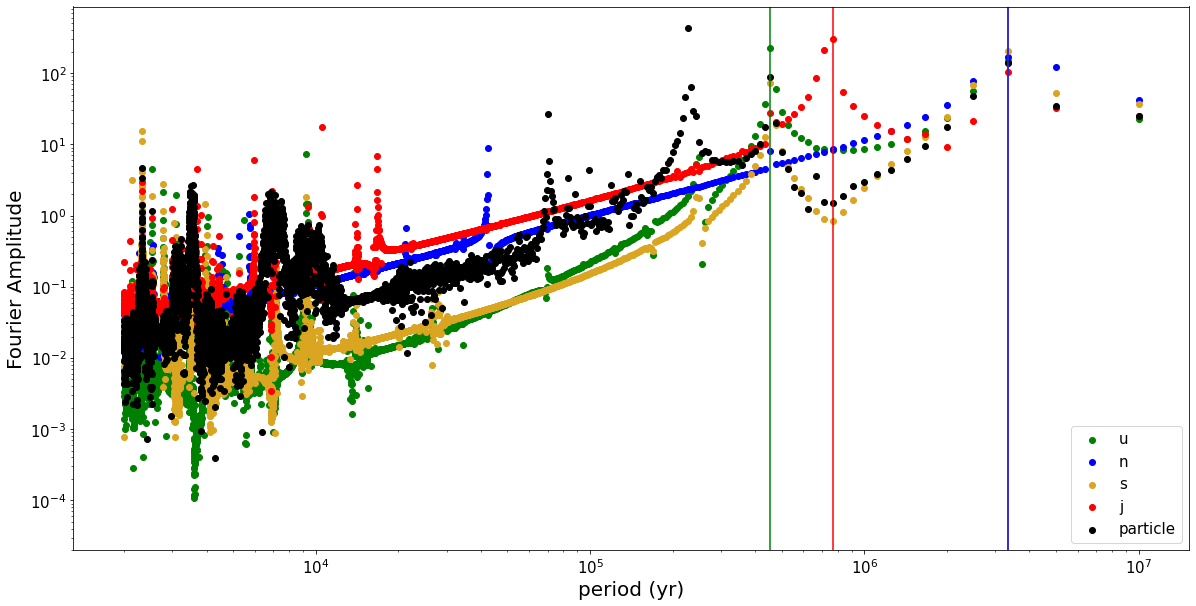

10001
10001 431.59119843452544


NameError: name 'new_pYh' is not defined

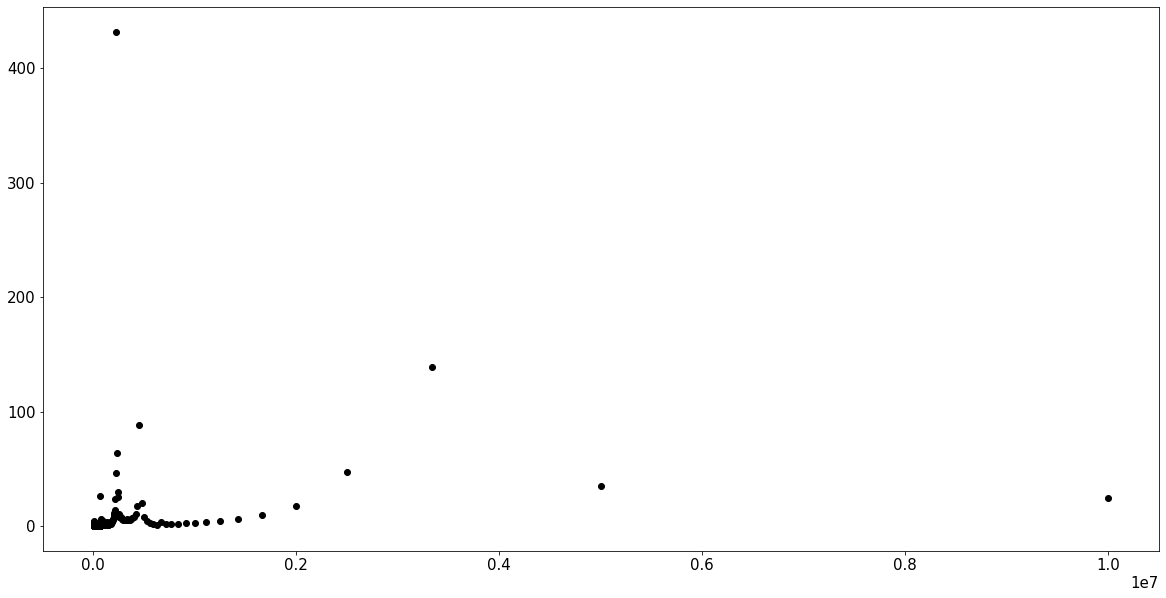

In [6]:
#plot the eccentricity spectra
import scipy
print(len(freq))
print(len(pYhu))
plt.scatter(1/freq[1:],pYhu[1:],label='u',c='g')
plt.scatter(1/freq[1:],pYhn[1:],label='n',c='b')
plt.scatter(1/freq[1:],pYhs[1:],label='s',c='goldenrod')
plt.scatter(1/freq[1:],pYhj[1:],label='j',c='r')
plt.scatter(1/freq[1:],pYh[1:],label='particle',c='k')

plt.axvline(x=1/freq[ihumax],c='g')
plt.axvline(x=1/freq[ihjmax],c='r')
plt.axvline(x=1/freq[ihsmax],c='goldenrod')
plt.axvline(x=1/freq[ihnmax],c='b')

plt.legend(loc='lower right')

plt.xlabel('period (yr)')
plt.ylabel('Fourier Amplitude')
plt.yscale('log')
plt.xscale('log')
maxp = np.max([humax,hsmax,hjmax,hnmax,pYh[1:].max()])

plt.ylim([0.00002,2*maxp]);
plt.show()

M = 200001
M = int(pYh[1:].max())
#hamming = scipy.signal.windows.hamming(M)

#hamming2 = scipy.signal.windows.hamming(len(h))
print(len(h))

pYh = np.abs(np.fft.rfft(h))


newh = h.copy()
print(len(h),pYh[1:].max())

plt.scatter(1/freq[1:],pYh[1:],label='particle',c='k')
plt.scatter(1/freq[1:],new_pYh[1:],label='particle hamm')
plt.scatter(1/freq[1:],new_pYh2[1:],label='particle hamm 2')

plt.xscale('log')
plt.yscale('log')
plt.show()

plt.scatter(range(len(h)-1),h[1:],label='particle',c='k')
plt.scatter(range(len(h)-1),newh[1:],label='particle hamm')
plt.scatter(range(len(h)-1),newh2[1:],label='particle hamm')

plt.show()
'''
dt=10
fs = np.linspace(1e-5,3.333e-3,2000);
times = np.arange(0,len(h),dt)
pgram = signal.lombscargle(t, h, freq[1:], normalize=False);
plt.plot(pgram)
'''

5001


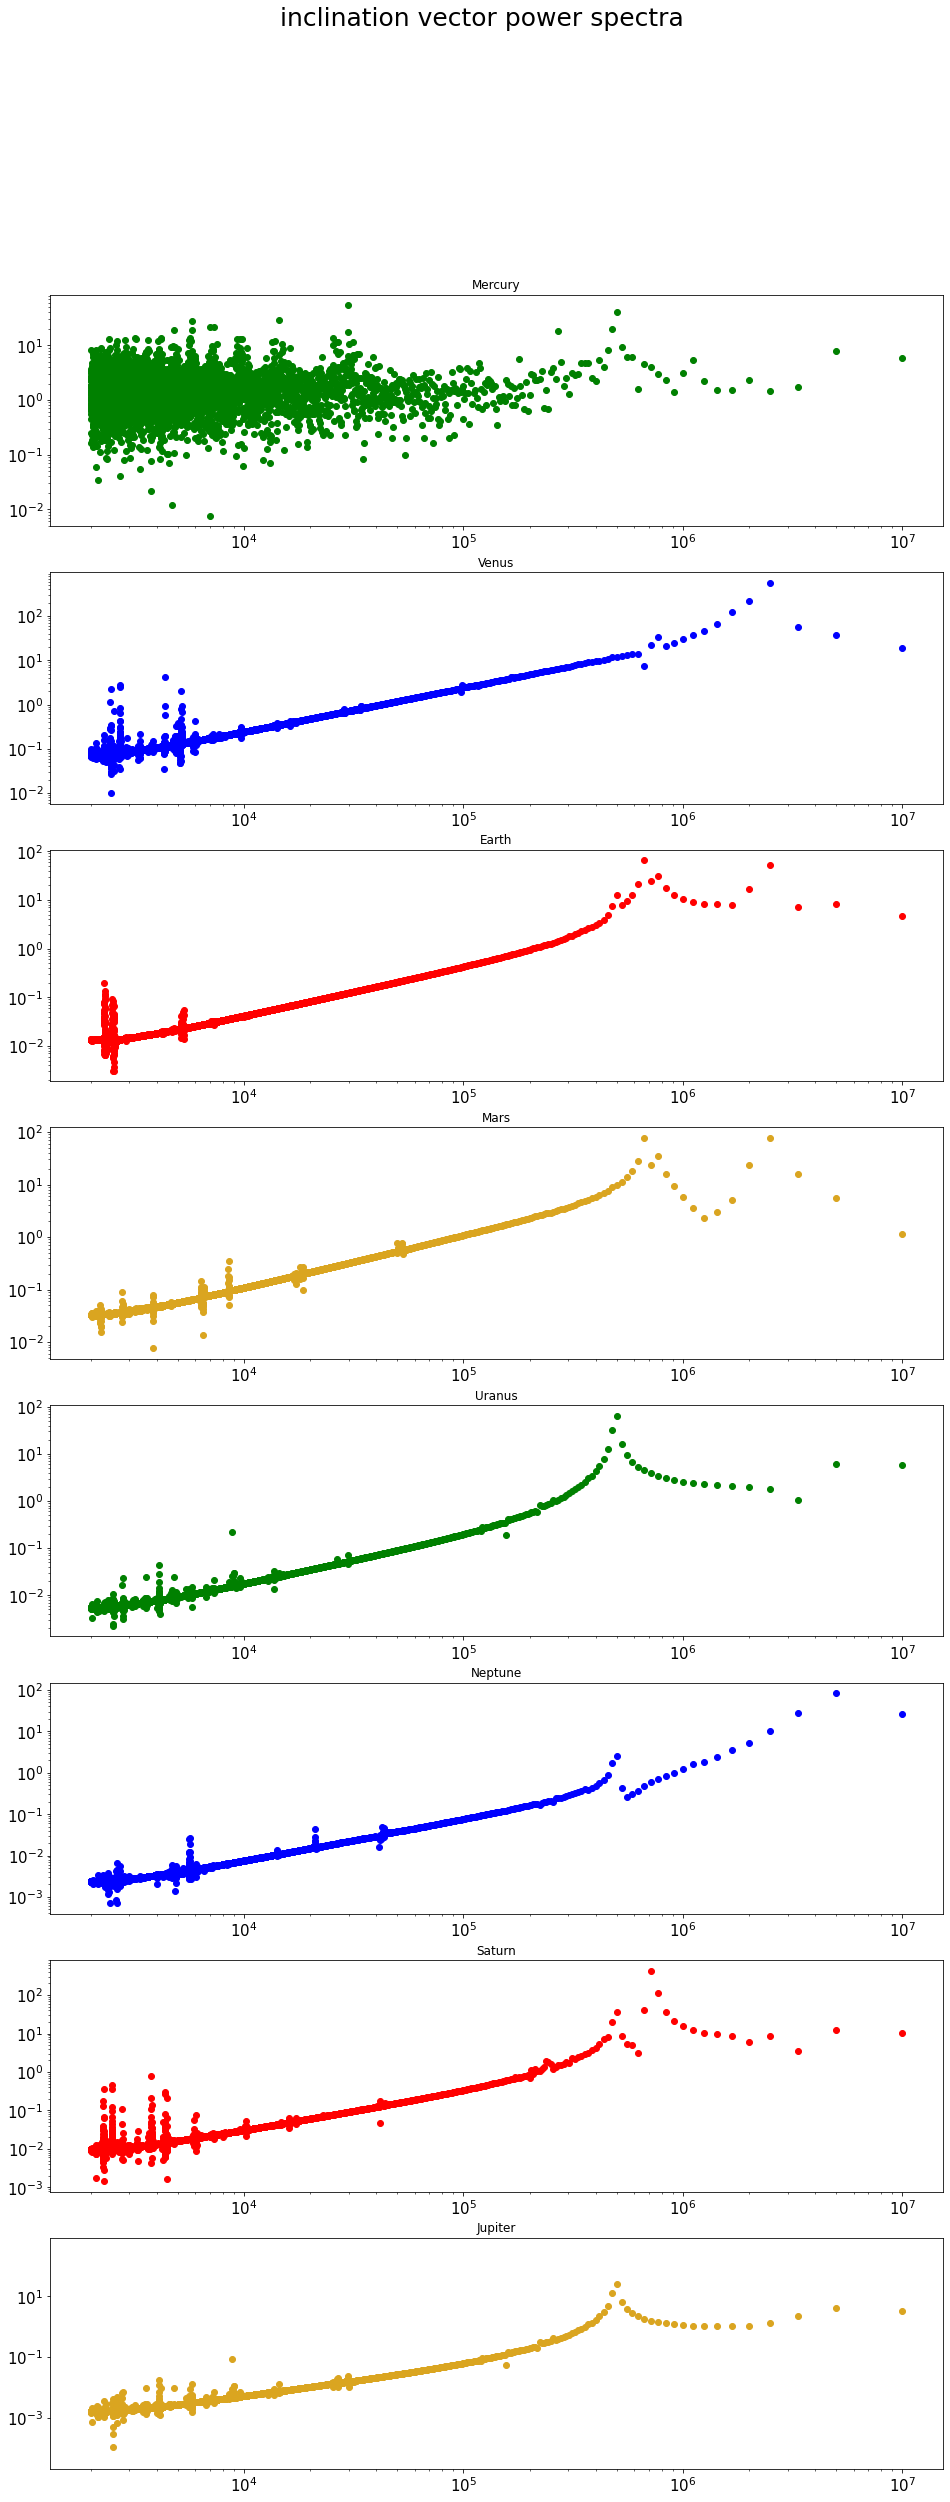

In [12]:
#plot the inclination spectra

print(len(pYpj))
fig,ax = plt.subplots(8,figsize=(16,40))
ax[0].scatter(1/freq[1:],pYpmc[1:],label='mc',c='g')
ax[1].scatter(1/freq[1:],pYpv[1:],label='v',c='b')
ax[3].scatter(1/freq[1:],pYpe[1:],label='e',c='goldenrod')
ax[2].scatter(1/freq[1:],pYpmr[1:],label='mr',c='r')

ax[4].scatter(1/freq[1:],pYpu[1:],label='u',c='g')
ax[5].scatter(1/freq[1:],pYpn[1:],label='n',c='b')
ax[7].scatter(1/freq[1:],pYps[1:],label='s',c='goldenrod')
ax[6].scatter(1/freq[1:],pYpj[1:],label='j',c='r')
ax[0].set_title('Mercury')
ax[1].set_title('Venus')
ax[2].set_title('Earth')
ax[3].set_title('Mars')

ax[4].set_title('Uranus')
ax[5].set_title('Neptune')
ax[7].set_title('Jupiter')
ax[6].set_title('Saturn')
#plt.scatter(1/freq[1:],pYp[1:],label='particle',c='k')
fig.suptitle('inclination vector power spectra',fontsize=25)
#plt.legend(loc='lower right')


#plt.axvline(x=1/freq[ipumax],c='g')
#plt.axvline(x=1/freq[ipjmax],c='r')
#plt.axvline(x=1/freq[ipsmax],c='goldenrod')
#plt.axvline(x=1/freq[ipnmax],c='b')

#plt.xlabel('period (yr)')
#plt.ylabel('Fourier Amplitude')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[3].set_yscale('log')
ax[3].set_xscale('log')

ax[4].set_yscale('log')
ax[4].set_xscale('log')
ax[5].set_yscale('log')
ax[5].set_xscale('log')
ax[6].set_yscale('log')
ax[6].set_xscale('log')
ax[7].set_yscale('log')
ax[7].set_xscale('log')
maxp = np.max([humax,hsmax,hjmax,hnmax,pYh[1:].max()])

plt.ylim([0.00002,2*maxp]);

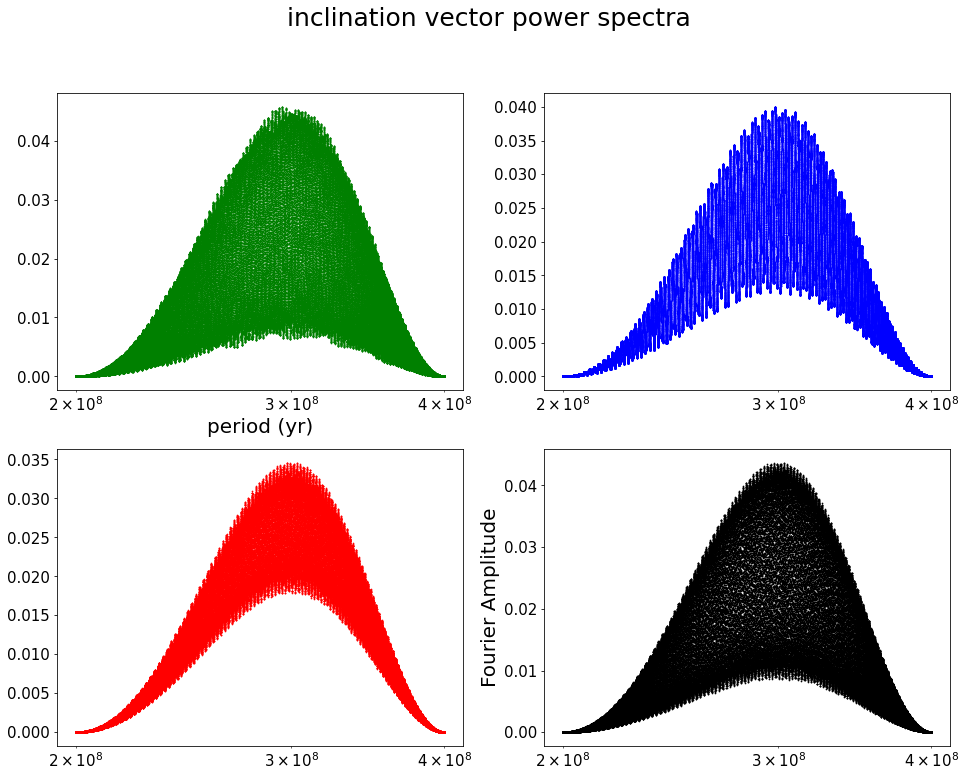

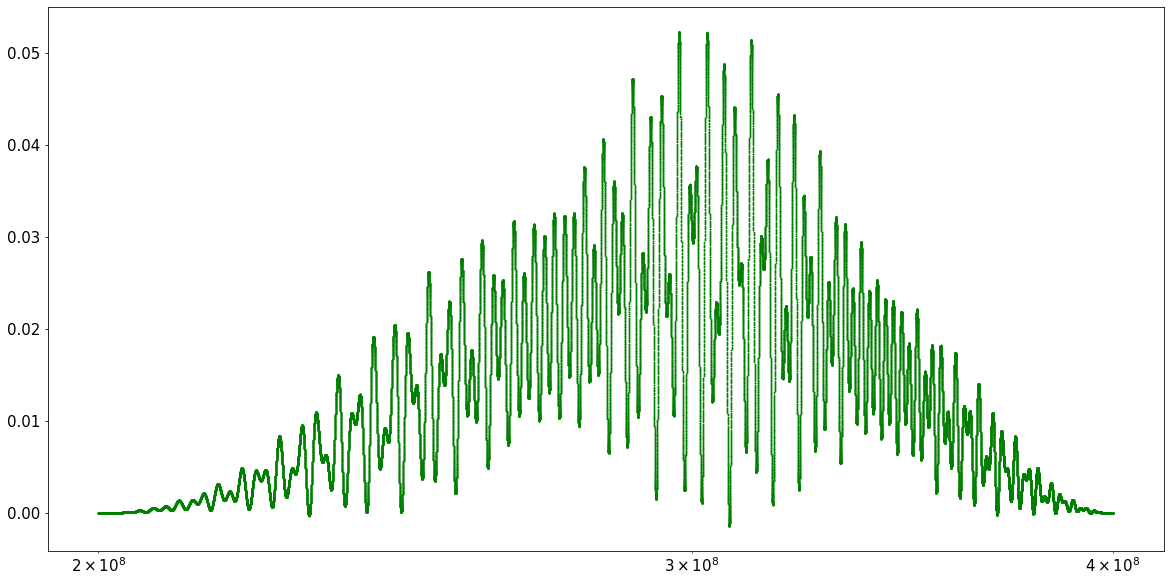

In [14]:
fig,ax = plt.subplots(2,2,figsize=(16,12))

import scipy.signal as sig
hanning = sig.windows.hann(len(pu[:]), sym=True)

puh = pu*hanning
pnh = pn*hanning
pjh = pj*hanning
psh = ps*hanning
ph = p*hanning

quh = qu*hanning
qnh = qn*hanning
qjh = qj*hanning
qsh = qs*hanning
qh = q*hanning

huh = hu*hanning
hnh = hn*hanning
hjh = hj*hanning
hsh = hs*hanning
hh = h*hanning

kuh = ku*hanning
knh = kn*hanning
kjh = kj*hanning
ksh = ks*hanning
kh = k*hanning

ax[0,0].scatter(t,puh[:],label='u',c='g',s=0.5)
ax[0,1].scatter(t,pnh[:],label='n',c='b',s=0.5)
ax[1,0].scatter(t,pjh[:],label='j',c='r',s=0.5)
ax[1,1].scatter(t,psh[:],label='particle',c='k',s=0.5)
fig.suptitle('inclination vector power spectra',fontsize=25)
#ax[0,0].legend(loc='lower right')

'''
plt.axvline(x=1/freq[ipumax],c='g')
plt.axvline(x=1/freq[ipjmax],c='r')
plt.axvline(x=1/freq[ipsmax],c='goldenrod')
plt.axvline(x=1/freq[ipnmax],c='b')
'''
ax[0,0].set_xlabel('period (yr)')
ax[1,1].set_ylabel('Fourier Amplitude')
#ax[0,0].set_yscale('log')
ax[0,1].set_xscale('log')
#ax[0,1].set_yscale('log')
ax[1,0].set_xscale('log')
#ax[1,0].set_yscale('log')
ax[1,1].set_xscale('log')
#ax[1,1].set_yscale('log')
ax[0,0].set_xscale('log')
maxp = np.max([humax,hsmax,hjmax,hnmax,pYh[1:].max()])

#plt.ylim([0.00002,2*maxp]);
plt.show()

plt.scatter(t,ph[:],label='u',c='g',s=0.5)
plt.xscale('log')
plt.show()

50001


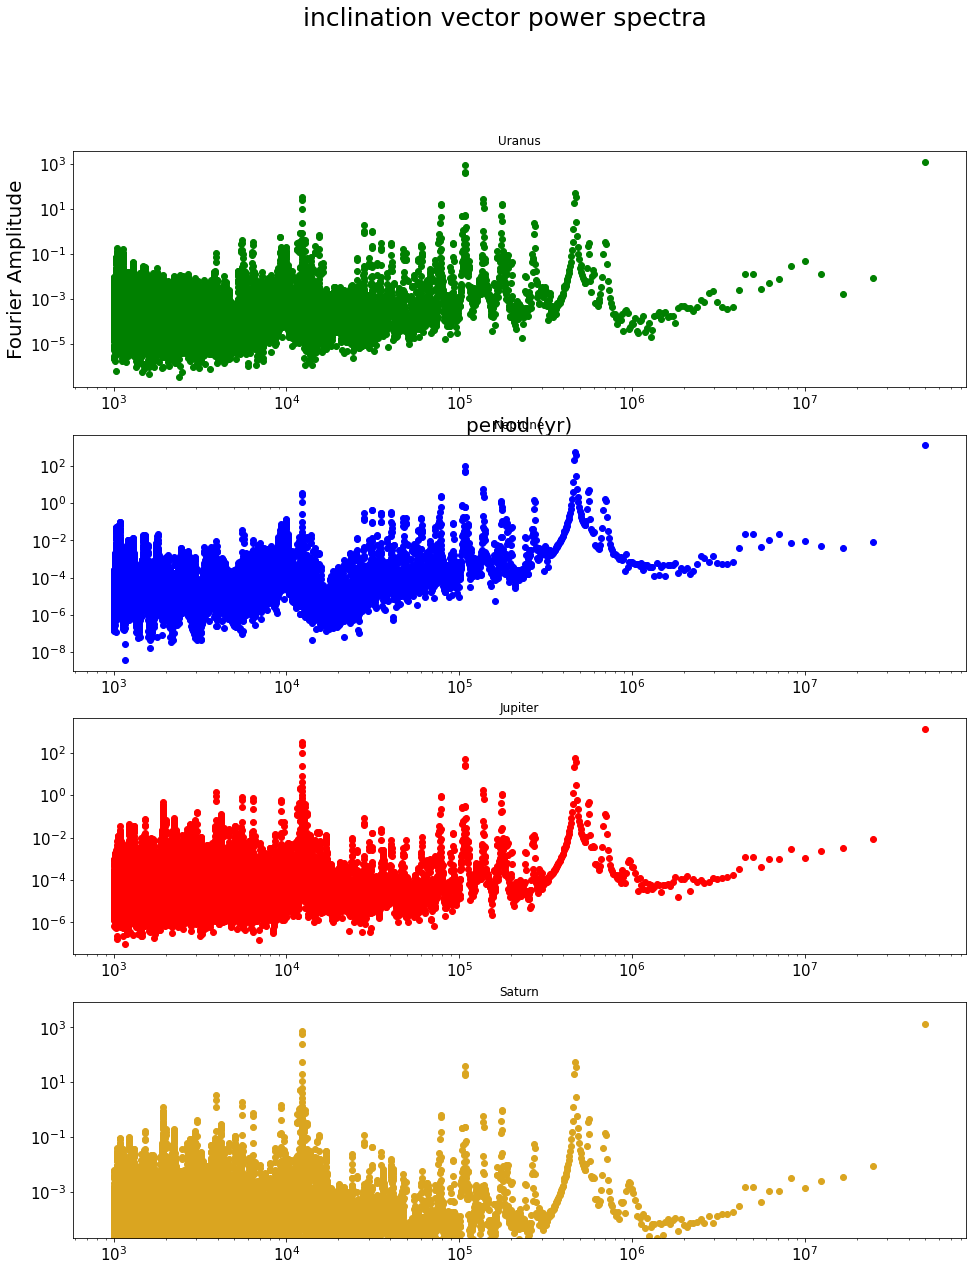

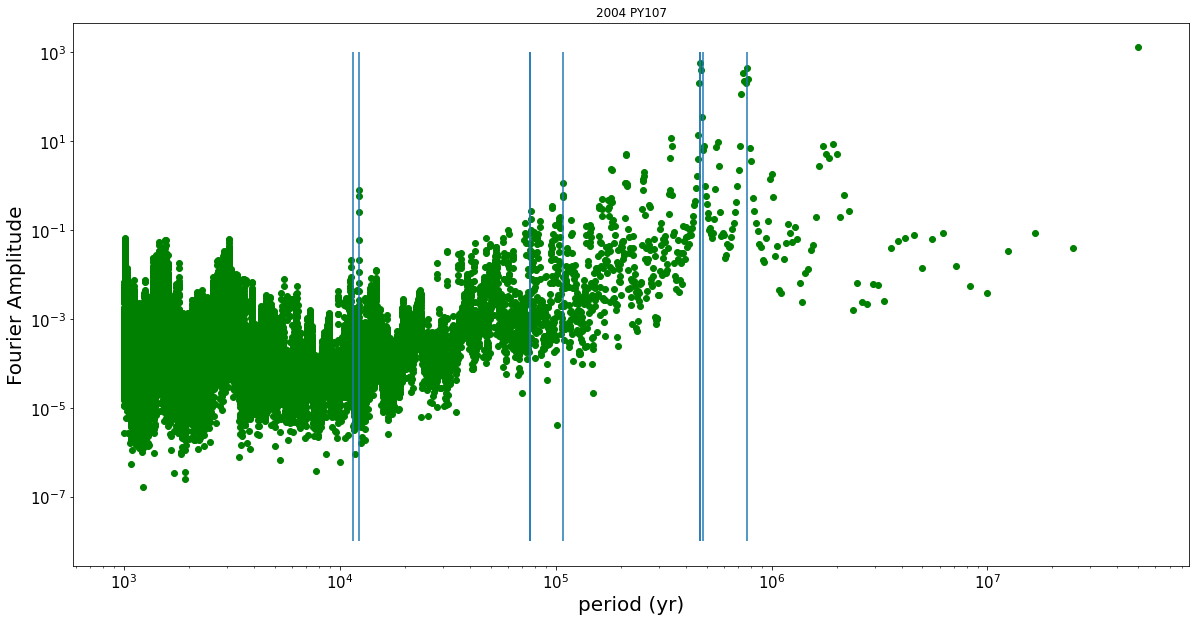

In [65]:
print(len(pYpj))
amp_scale = np.mean(hanning)**(-1)
ene_scale = np.mean(hanning)**2/np.mean(hanning**2)
fig,ax = plt.subplots(4,figsize=(16,20))
pYunew = np.abs(np.fft.rfft(puh))*amp_scale
pYnnew = np.abs(np.fft.rfft(pnh))*amp_scale
pYjnew = np.abs(np.fft.rfft(pjh))*amp_scale
pYsnew = np.abs(np.fft.rfft(psh))*amp_scale
pYnew = np.abs(np.fft.rfft(ph))*amp_scale

qYunew = np.abs(np.fft.rfft(quh))*amp_scale
qYnnew = np.abs(np.fft.rfft(qnh))*amp_scale
qYjnew = np.abs(np.fft.rfft(qjh))*amp_scale
qYsnew = np.abs(np.fft.rfft(qsh))*amp_scale
qYnew = np.abs(np.fft.rfft(qh))*amp_scale

hYunew = np.abs(np.fft.rfft(huh))*amp_scale
hYnnew = np.abs(np.fft.rfft(hnh))*amp_scale
hYjnew = np.abs(np.fft.rfft(hjh))*amp_scale
hYsnew = np.abs(np.fft.rfft(hsh))*amp_scale
hYnew = np.abs(np.fft.rfft(hh))*amp_scale

kYunew = np.abs(np.fft.rfft(kuh))*amp_scale
kYnnew = np.abs(np.fft.rfft(knh))*amp_scale
kYjnew = np.abs(np.fft.rfft(kjh))*amp_scale
kYsnew = np.abs(np.fft.rfft(ksh))*amp_scale
kYnew = np.abs(np.fft.rfft(kh))*amp_scale
                           
                           
                           
ax[0].scatter(1/freq[1:],pYunew[1:],label='u',c='g')
ax[1].scatter(1/freq[1:],pYnnew[1:],label='n',c='b')
ax[2].scatter(1/freq[1:],pYjnew[1:],label='j',c='r')
ax[3].scatter(1/freq[1:],pYsnew[1:],label='s',c='goldenrod')

ax[0].set_title('Uranus')
ax[1].set_title('Neptune')
ax[2].set_title('Jupiter')
ax[3].set_title('Saturn')

fig.suptitle('inclination vector power spectra',fontsize=25)
#plt.legend(loc='lower right')

ax[0].set_xlabel('period (yr)')
ax[0].set_ylabel('Fourier Amplitude')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[3].set_yscale('log')
ax[3].set_xscale('log')
maxp = np.max([humax,hsmax,hjmax,hnmax,pYh[1:].max()])

plt.ylim([0.00002,2*maxp]);
plt.show()

plt.scatter(1/freq[1:],pYnew[1:],label='u',c='g')
plt.title('2004 PY107')

plt.vlines(1/g,ymin=1e-8,ymax=1e3)
plt.vlines(1/s,ymin=1e-8,ymax=1e3)

#'''
plt.vlines(1/g5,ymin=1e-8,ymax=1e3)
plt.vlines(1/g6,ymin=1e-8,ymax=1e3)
plt.vlines(1/g7,ymin=1e-8,ymax=1e3)
plt.vlines(1/g8,ymin=1e-8,ymax=1e3)

plt.vlines(1/s6,ymin=1e-8,ymax=1e3)
plt.vlines(1/s7,ymin=1e-8,ymax=1e3)
plt.vlines(1/s8,ymin=1e-8,ymax=1e3)

plt.vlines(1/z1,ymin=1e-8,ymax=1e3)
plt.vlines(1/z2,ymin=1e-8,ymax=1e3)
plt.vlines(1/z3,ymin=1e-8,ymax=1e3)
plt.vlines(1/z4,ymin=1e-8,ymax=1e3)
plt.vlines(1/z5,ymin=1e-8,ymax=1e3)
plt.vlines(1/z6,ymin=1e-8,ymax=1e3)
plt.vlines(1/z7,ymin=1e-8,ymax=1e3)
plt.vlines(1/z8,ymin=1e-8,ymax=1e3)
plt.vlines(1/z9,ymin=1e-8,ymax=1e3)
#plt.vlines(1/z10,ymin=1e-8,ymax=1e3)
#plt.vlines(1/z11,ymin=1e-8,ymax=1e3)
#plt.vlines(1/z12,ymin=1e-8,ymax=1e3)
#'''
plt.xlabel('period (yr)')
plt.ylabel('Fourier Amplitude')
plt.yscale('log')
plt.xscale('log')

50001


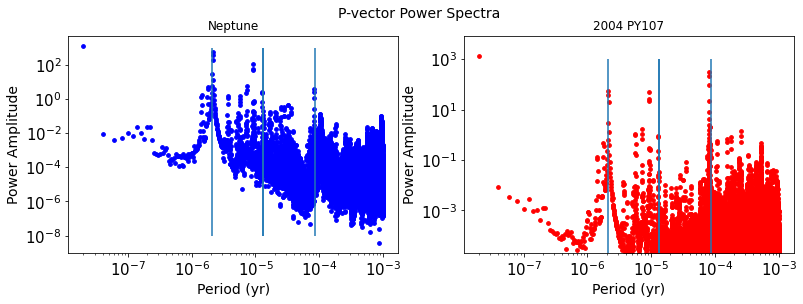

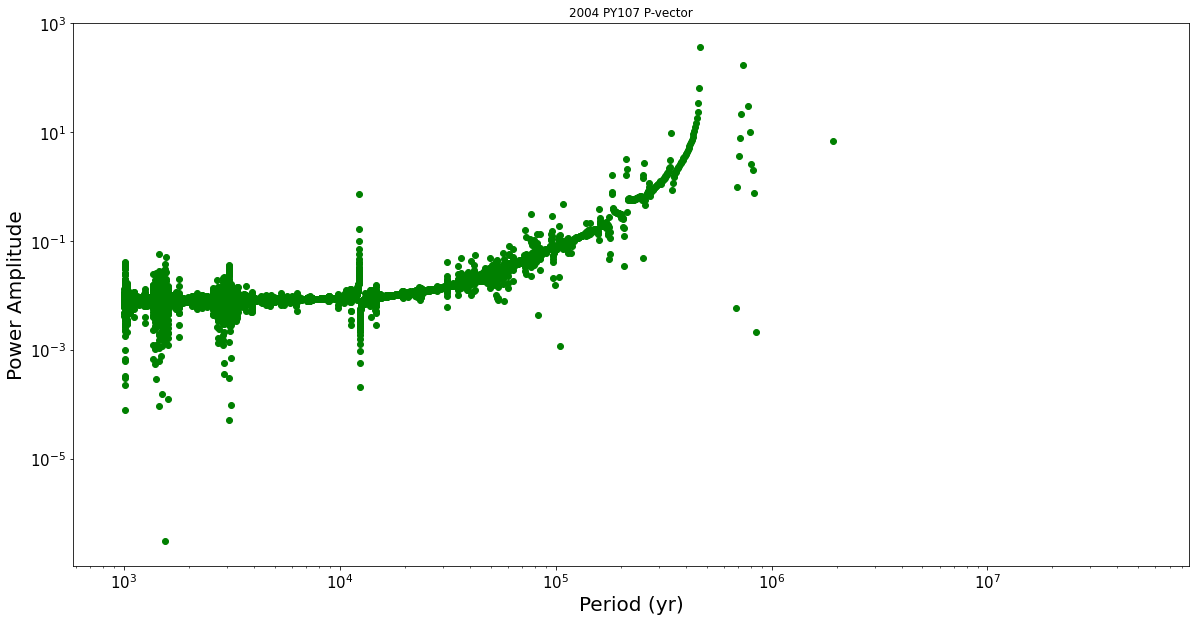

In [41]:
print(len(pYpj))
amp_scale = np.mean(hanning)**(-1)
ene_scale = np.mean(hanning)**2/np.mean(hanning**2)
fig,ax = plt.subplots(1,2,figsize=(13,4))
pYunew = np.abs(np.fft.rfft(puh))*amp_scale
pYnnew = np.abs(np.fft.rfft(pnh))*amp_scale
pYjnew = np.abs(np.fft.rfft(pjh))*amp_scale
pYsnew = np.abs(np.fft.rfft(psh))*amp_scale
pYnew = np.abs(np.fft.rfft(ph))*amp_scale

qYunew = np.abs(np.fft.rfft(quh))*amp_scale
qYnnew = np.abs(np.fft.rfft(qnh))*amp_scale
qYjnew = np.abs(np.fft.rfft(qjh))*amp_scale
qYsnew = np.abs(np.fft.rfft(qsh))*amp_scale
qYnew = np.abs(np.fft.rfft(qh))*amp_scale

hYunew = np.abs(np.fft.rfft(huh))*amp_scale
hYnnew = np.abs(np.fft.rfft(hnh))*amp_scale
hYjnew = np.abs(np.fft.rfft(hjh))*amp_scale
hYsnew = np.abs(np.fft.rfft(hsh))*amp_scale
hYnew = np.abs(np.fft.rfft(hh))*amp_scale

kYunew = np.abs(np.fft.rfft(kuh))*amp_scale
kYnnew = np.abs(np.fft.rfft(knh))*amp_scale
kYjnew = np.abs(np.fft.rfft(kjh))*amp_scale
kYsnew = np.abs(np.fft.rfft(ksh))*amp_scale
kYnew = np.abs(np.fft.rfft(kh))*amp_scale
                           
                           
                           
ax[0].scatter(freq[1:],pYnnew[1:],label='n',c='b',s=14)
ax[1].scatter(freq[1:],pYjnew[1:],label='j',c='r',s=14)


ax[0].set_title('Neptune')
ax[1].set_title('2004 PY107')

fig.suptitle('P-vector Power Spectra',fontsize=14)
#plt.legend(loc='lower right')

ax[0].set_xlabel('Period (yr)',fontsize=14)
ax[0].set_ylabel('Power Amplitude',fontsize=14)
ax[1].set_xlabel('Period (yr)',fontsize=14)
ax[1].set_ylabel('Power Amplitude',fontsize=14)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[0].vlines(freq[ihjmax],ymin=1e-8,ymax=1e3)
ax[0].vlines(freq[ihumax],ymin=1e-8,ymax=1e3)
ax[0].vlines(freq[ihnmax],ymin=1e-8,ymax=1e3)
ax[0].vlines(freq[ihsmax],ymin=1e-8,ymax=1e3)
ax[1].vlines(freq[ihjmax],ymin=2e-5,ymax=1e3)
ax[1].vlines(freq[ihumax],ymin=1e-5,ymax=1e3)
ax[1].vlines(freq[ihnmax],ymin=1e-5,ymax=1e3)
ax[1].vlines(freq[ihsmax],ymin=1e-5,ymax=1e3)

maxp = np.max([humax,hsmax,hjmax,hnmax,pYh[1:].max()])

plt.ylim([0.00002,2*maxp]);
plt.show()

plt.scatter(1/freq[1:],Yp[1:],label='u',c='g')
plt.title('2004 PY107 P-vector')

plt.xlabel('Period (yr)')
plt.ylabel('Power Amplitude')
plt.yscale('log')
plt.xscale('log')

try a simple filter to zero out the planet frequencies

(656.0535774376635+0j)
(80.16579786709526+87.7494192492673j)
(134.43206284620976-203.14818003636867j)
(208.08313009030246+130.79952182366196j)


/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


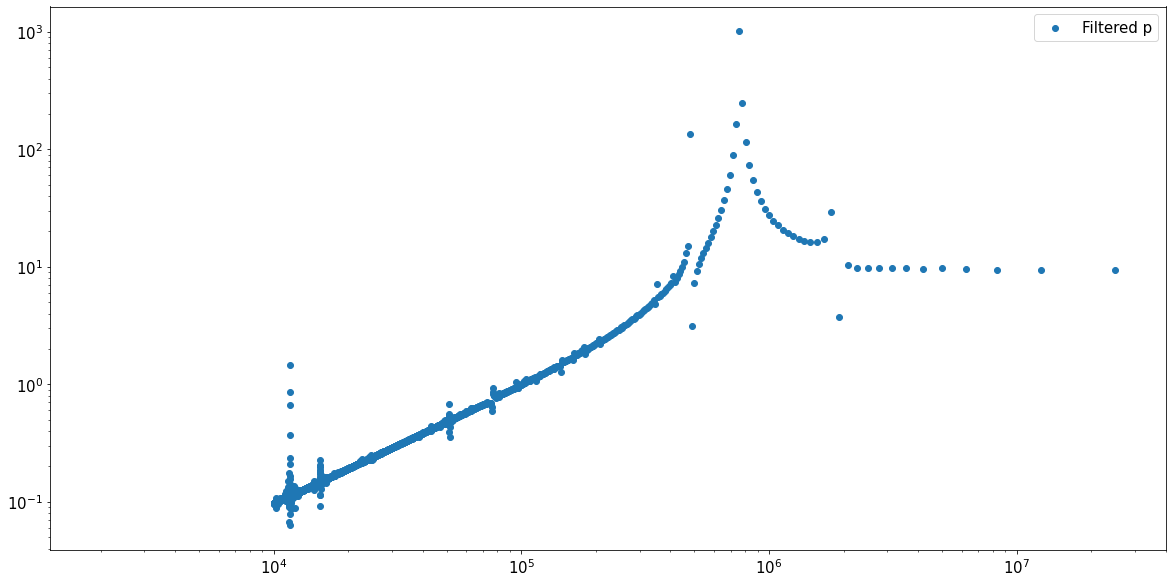

/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide


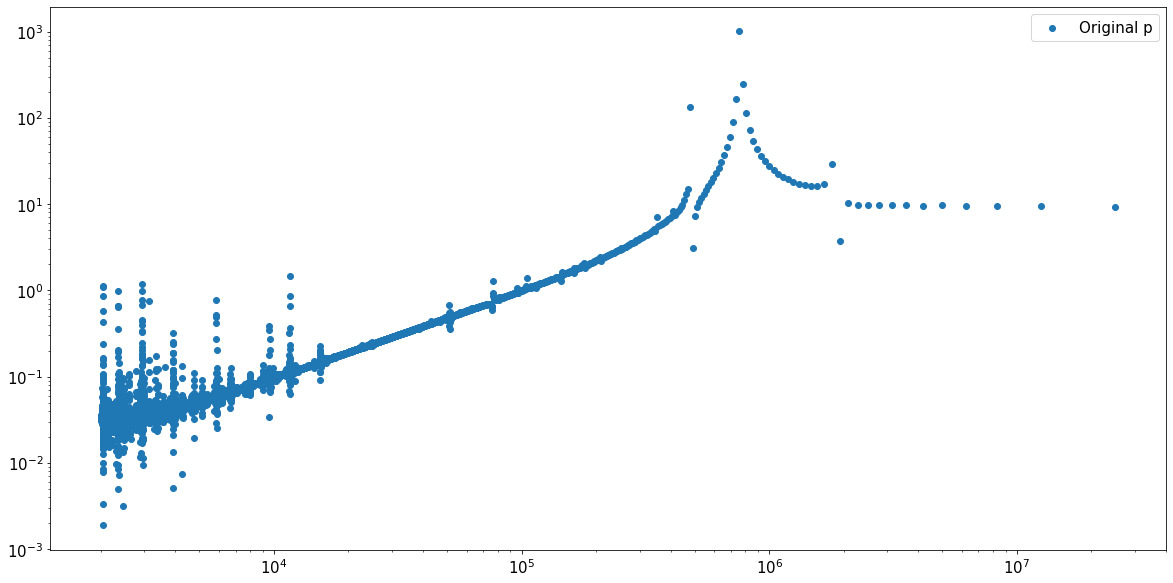

Calc: 0.0158453475199965
AstDys Sin(Inc): 0.011229
Calc: 0.08679062846848154
AstDys Ecc 0.0891079
5294 149.34008235950756


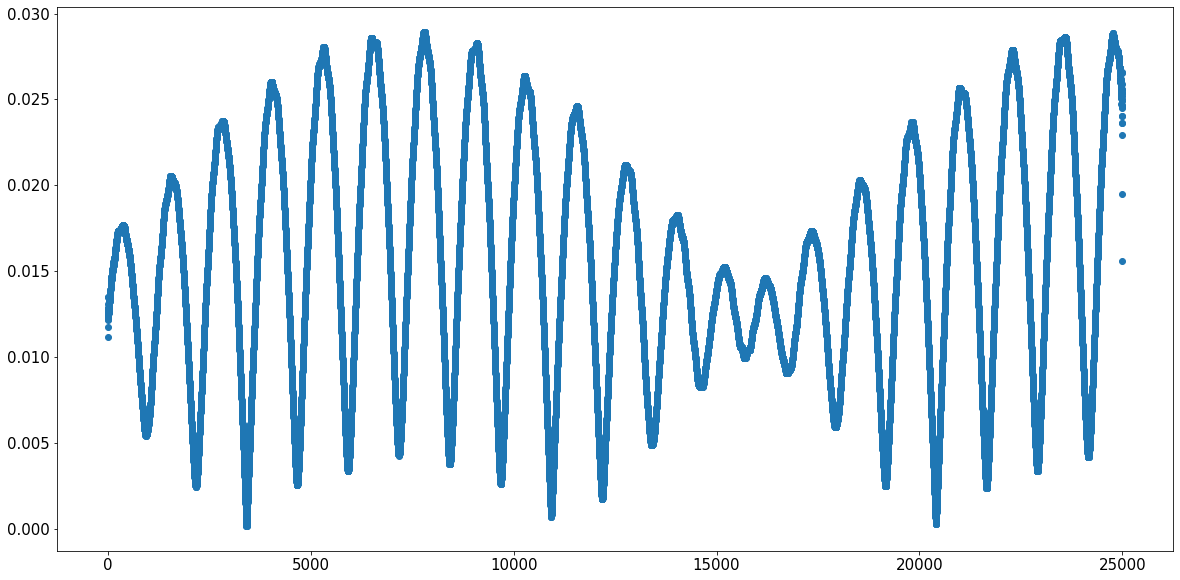

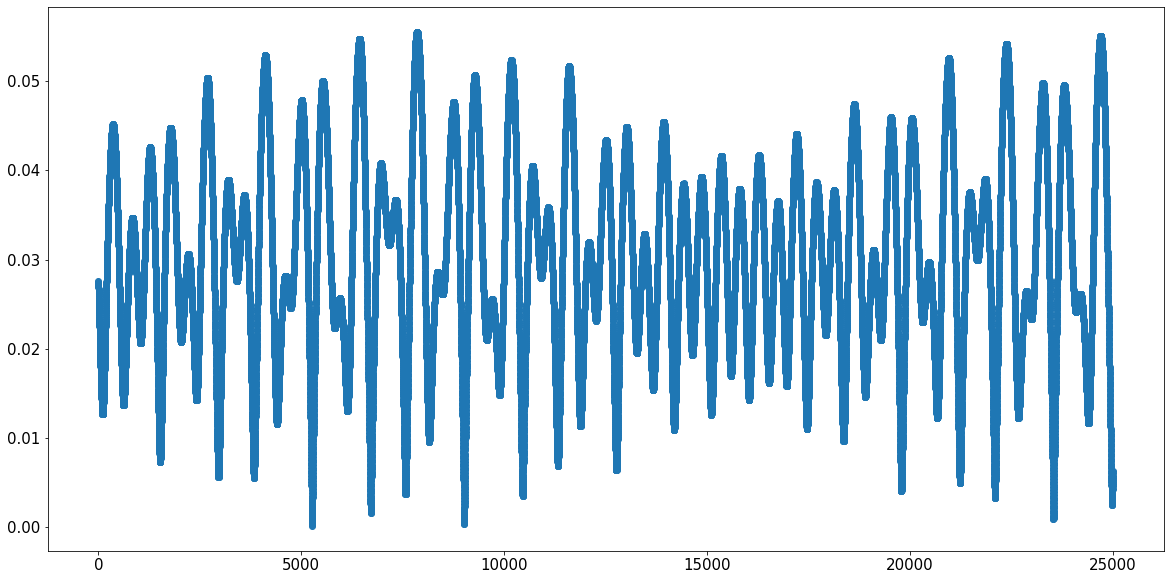

/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


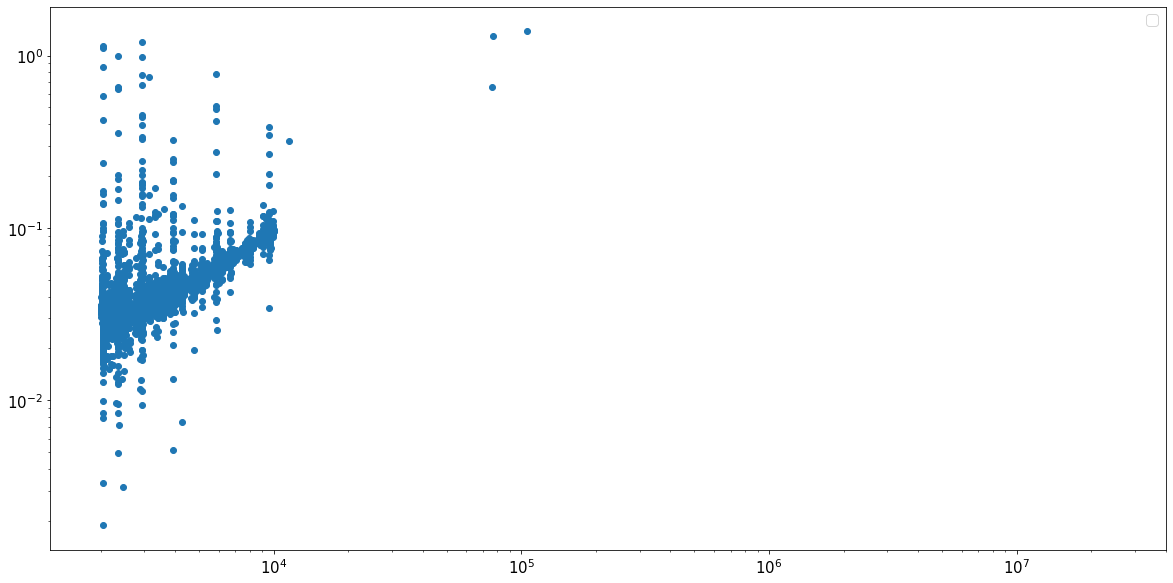

In [428]:
#make copies of the FFT outputs
Yp_f = Yp.copy()
Yq_f = Yq.copy()
Yh_f = Yh.copy()
Yk_f = Yk.copy()

print(Yp_f.max())
print(Yq_f.max())
print(Yh_f.max())
print(Yk_f.max())

imax = len(Yp)
#disregard antyhing with a period shorter than 5000 years
freqlim = 1./10000.
#disregard frequencies for which any planet has power at higher than 10% the max
pth = 0.75

spread = 1
limit_ind = np.where(freq >= freqlim)[0]

spread = 1

Yp_f[limit_ind] = 0
Yq_f[limit_ind] = 0
Yh_f[limit_ind] = 0
Yk_f[limit_ind] = 0
Yp_f[0] = 0
Yq_f[0] = 0
Yh_f[0] = 0
Yk_f[0] = 0
#'''
for i in range(0,imax-1):
    if (pYpu[i]>pth*pumax or pYpj[i]>pth*pjmax or pYps[i]>pth*psmax 
       or pYpn[i]>pth*pnmax or freq[i]>freqlim):
        Yp_f[i]=0
    if (pYqu[i]>pth*qumax or pYqj[i]>pth*qjmax or pYqs[i]>pth*qsmax 
       or pYqn[i]>pth*qnmax or freq[i]>freqlim):
        Yq_f[i]=0
    if (pYhu[i]>pth*humax or pYhj[i]>pth*hjmax or pYhs[i]>pth*hsmax 
       or pYhn[i]>pth*hnmax or freq[i]>freqlim):
        Yh_f[i]=0
    if (pYku[i]>pth*kumax or pYkj[i]>pth*kjmax or pYks[i]>pth*ksmax 
       or pYkn[i]>pth*knmax or freq[i]>freqlim):
        Yk_f[i]=0
'''        
for i in range(0,imax-1):
    if freq[i]>freqlim:
        Yp_f[i]=0
    if freq[i]>freqlim:
        Yq_f[i]=0
    if freq[i]>freqlim:
        Yh_f[i]=0
    if freq[i]>freqlim:
        Yk_f[i]=0
'''

    
p_f = np.fft.irfft(Yp_f,len(p))
q_f = np.fft.irfft(Yq_f,len(q))
h_f = np.fft.irfft(Yh_f,len(h))
k_f = np.fft.irfft(Yk_f,len(k))

plt.scatter(1/freq,np.abs(Yk_f),label='Filtered p')
#plt.scatter(1/freq,test)
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.show()
plt.scatter(1/freq,np.abs(np.fft.rfft(k)),label='Original p')
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.show()

sini = np.sqrt(p*p+q*q)
sini_f = np.sqrt(p_f*p_f + q_f*q_f)
ecc = np.sqrt(h*h+k*k)
ecc_f = np.sqrt(h_f*h_f + k_f*k_f)

print('Calc:',np.mean(sini_f))
print('AstDys Sin(Inc):',0.0112290)
#print('AstDys 2004KF19', 0.0344540)
print('Calc:',np.mean(ecc_f))
print('AstDys Ecc', 0.0891079)
#print('AstDys 2004KF19:', 0.0578858)

print(ihjmax,pjmax)



Yk_1 = np.abs(Yk_f)
Yh_1 = np.abs(Yh_f)
Yp_1 = np.abs(Yp_f)
Yq_1 = np.abs(Yq_f)
plt.scatter(range(len(sini)),sini_f)
plt.show()

plt.scatter(range(len(sini)),sini)
plt.show()

plt.scatter(1/freq,abs(Yk_1-np.abs(Yk.copy())))
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.show()

# Secular Theory

In [506]:
#set up all the FFT power spectra, etc
import bin_to_df
import rebound
#the outputs are not exact, but it's about 
#sbody = '2004PY107'
#objname = '2004 PY107'
sbody = '15789'
objname = '15789'

#sbody = '2004KF19'
#objname = '2004KF19'
#path = 'Asteroids/'+objname
path = 'TNOs/'+objname

archive = rebound.SimulationArchive(path+'/archive.bin')
series = bin_to_df.bin_to_df(objname,archive)
t = series['t'].values
dt=int(t[1])
a = series['a'].values
e = series['ecc'].values
inc = series['inc'].values
#omega = series['omega'].values
#Omega = series['Omega'].values
#M = series['M'].values
h = series['h'].values
k = series['k'].values
p = series['p'].values
q = series['q'].values
hj = series['hj'].values
kj = series['kj'].values
pj = series['pj'].values
qj = series['qj'].values
hs = series['hs'].values
ks = series['ks'].values
ps = series['ps'].values
qs = series['qs'].values
hu = series['hu'].values
ku = series['ku'].values
pu = series['pu'].values
qu = series['qu'].values
hn = series['hn'].values
kn = series['kn'].values
pn = series['pn'].values
qn = series['qn'].values

dt = int(t[1])
n = int(len(h))
freq = np.fft.rfftfreq(n,d=dt)

#particle eccentricity vectors
Yh= np.fft.rfft(h)
Yk = np.fft.rfft(k)

#giant planets
Yhu = np.fft.rfft(hu)
Yhj = np.fft.rfft(hj)
Yhn = np.fft.rfft(hn)
Yhs = np.fft.rfft(hs)
Yku = np.fft.rfft(ku)
Ykj = np.fft.rfft(kj)
Ykn = np.fft.rfft(kn)
Yks = np.fft.rfft(ks)

#particle inclination vectors
Yp= np.fft.rfft(p)
Yq = np.fft.rfft(q)
#giant planets
Ypu = np.fft.rfft(pu)
Ypj = np.fft.rfft(pj)
Ypn = np.fft.rfft(pn)
Yps = np.fft.rfft(ps)
Yqu = np.fft.rfft(qu)
Yqj = np.fft.rfft(qj)
Yqn = np.fft.rfft(qn)
Yqs = np.fft.rfft(qs)

ihmax = np.argmax(np.abs(Yh[1:]))+1
ikmax = np.argmax(np.abs(Yk[1:]))+1
ihumax = np.argmax(np.abs(Yhu[1:]))+1
ihnmax = np.argmax(np.abs(Yhn[1:]))+1 
ihsmax = np.argmax(np.abs(Yhs[1:]))+1 
ihjmax = np.argmax(np.abs(Yhj[1:]))+1 
ikumax = np.argmax(np.abs(Yku[1:]))+1 
iknmax = np.argmax(np.abs(Ykn[1:]))+1
iksmax = np.argmax(np.abs(Yks[1:]))+1
ikjmax = np.argmax(np.abs(Ykj[1:]))+1 

In [507]:
#Secular Resonances

rev = 1296000
g = freq[ihmax]
s = freq[ipmax]

g5 = freq[ihjmax]
g6 = freq[ihsmax]
g7 = freq[ihumax]
g8 = freq[ihnmax]
s5 = 0
s6 = freq[ipsmax]
s7 = freq[ipumax]
s8 = freq[ipnmax]

z1 = abs(g+s-g6-s6)
z2 = abs(g+s-g5-s7)
z3 = abs(g+s-g5-s6)
z4 = abs(g-2*g6+g5)
z5 = abs(g-2*g6+g7)
z6 = abs(s-s6-g5+g6)
z7 = abs(g-3*g6+2*g5)
z8 = abs(2*(g-g6)+s-s6)
z9 = abs(3*(g-g6)+s-s6)

print(1/g5,1/g6,1/g7,1/g8)
print(1/s6,1/s7,1/s8)
print(1/g,1/z1,1/z2,1/z3,1/z4)
print(1/s,1/z5,1/z6,1/z7,1/z8,1/z9,1/z10,1/z11,1/z12)

g5 = 4.24/rev
g6 = 28.22/rev
g7 = 3.08/rev
g8 = 0.67/rev
s6 = 26.34/rev
s7 = 2.99/rev
s8 = 0.69/rev
z1 = abs(g+s-g6-s6)
z2 = abs(g+s-g5-s7)
z3 = abs(g+s-g5-s6)
z4 = abs(g-2*g6+g5)
z5 = abs(g-2*g6+g7)
z6 = abs(s-s6-g5+g6)
z7 = abs(g-3*g6+2*g5)
z8 = abs(2*(g-g6)+s-s6)
z9 = abs(3*(g-g6)+s-s6)

print(1/g5,1/g6,1/g7,1/g8)
print(1/s6,1/s7,1/s8)
print(1/g,1/z1,1/z2,1/z3,1/z4)
print(1/s,1/z5,1/z6,1/z7,1/z8,1/z9,1/z10,1/z11,1/z12)

334481.6053511705 304908.53658536583 45897.20055071133 304908.53658536583
49217.51968503937 49217.51968503937 432943.7229437229
50004999.99999999 43388.2863340564 43941.12478031634 43941.12478031634 281718.3098591549
1886981.1320754713 65580.32786885244 51287.179487179485 260442.70833333334 38012.16267578867 33821.44064930672 45795.05300353357 45973.74955658035 17003.411178168462
305660.37735849054 45924.87597448618 420779.2207792208 1934328.358208955
49202.73348519362 433444.81605351163 1878260.8695652175
50004999.99999999 24068.07196287589 198856.23073485217 43391.97873684251 24839.91927833451
1886981.1320754713 24299.658623933938 774568.950062031 17018.128981315516 15796.911422728199 11756.655043617726 45795.05300353357 45973.74955658035 17003.411178168462


328


/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in true_divide


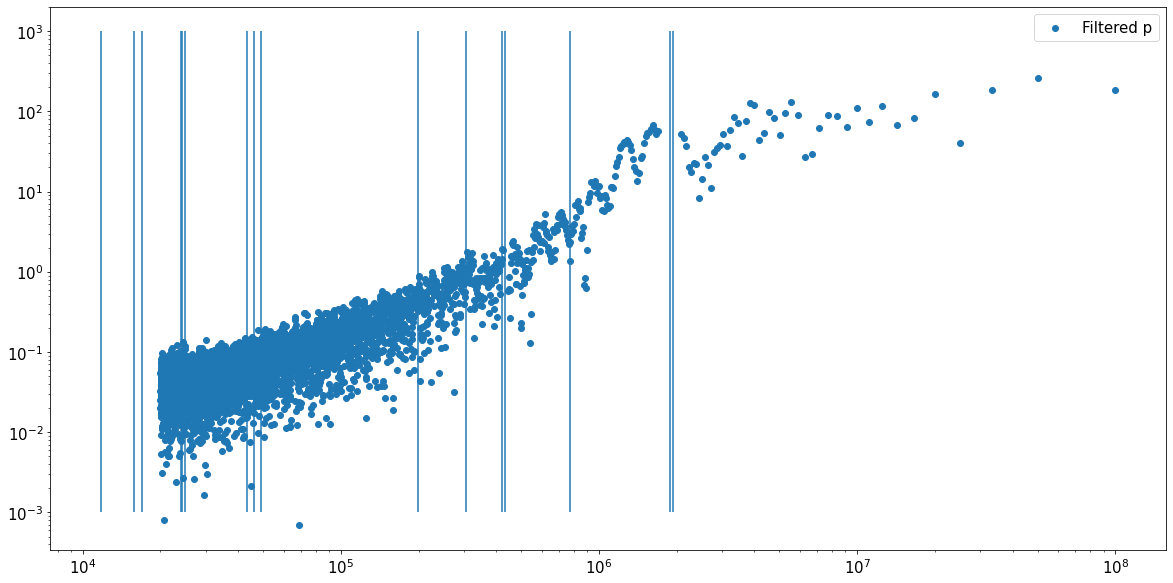

/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide


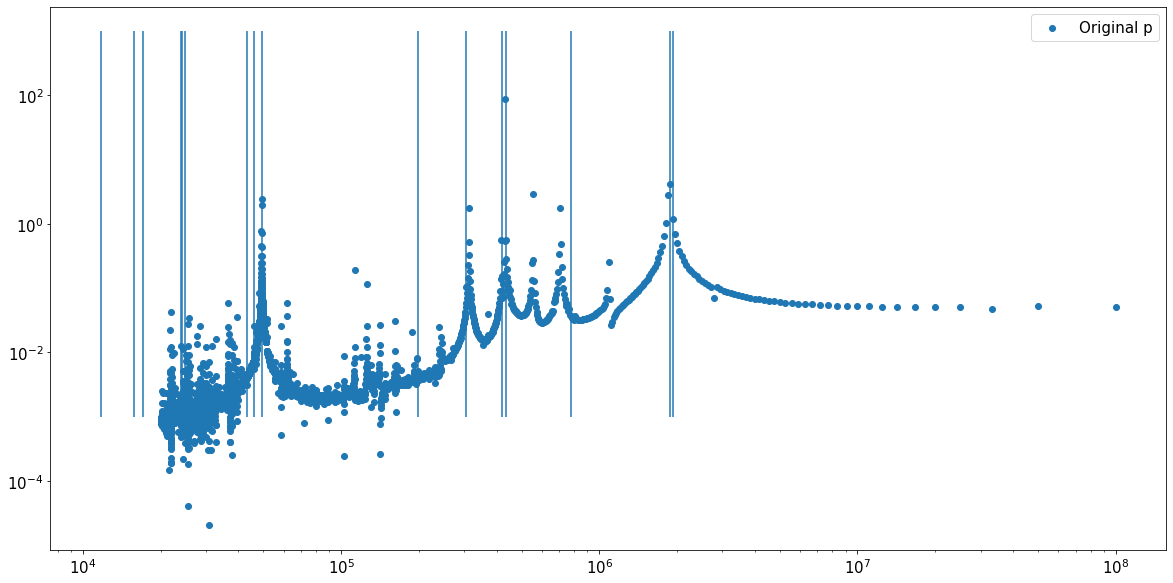

Calc: 0.12674852001896914
AstDys Sin(Inc): 0.1019159
Calc: 0.6326111953183272
AstDys Ecc 0.1841545


In [515]:
#make copies of the FFT outputs
Yp_f = Yp.copy()
Yq_f = Yq.copy()
Yh_f = Yh.copy()
Yk_f = Yk.copy()

#z10,z11,s7,z6

Yp_f[0]=0
Yq_f[0]=0
Yh_f[0]=0
Yk_f[0]=0

print(np.where(freq>=g5)[0][0])

#secresind = [np.where(freq >= g5)[0][0],np.where(freq >= g6)[0][0],np.where(freq >= g7)[0][0],np.where(freq >= g8)[0][0],np.where(freq >= s6)[0][0],np.where(freq >= s7)[0][0],np.where(freq >= s8)[0][0],np.where(freq >= z1)[0][0],np.where(freq >= z2)[0][0],np.where(freq >= z3)[0][0],np.where(freq >= z4)[0][0],np.where(freq >= z5)[0][0],np.where(freq >= z6)[0][0],np.where(freq >= z7)[0][0],np.where(freq >= z8)[0][0],np.where(freq >= z9)[0][0]]

#Identical to above method
#secresind1 = [np.where(freq <= g5)[0][0],np.where(freq >= g6)[0][0],np.where(freq >= g7)[0][0],np.where(freq >= g8)[0][0],np.where(freq >= z1)[0][0],np.where(freq >= z4)[0][0],np.where(freq >= z5)[0][0],np.where(freq >= z7)[0][0],np.where(freq >= z8)[0][0],np.where(freq >= z9)[0][0]]
#secresind2 = [np.where(freq >= s6)[0][0],np.where(freq >= s7)[0][0],np.where(freq >= s8)[0][0],np.where(freq >= z1)[0][0],np.where(freq >= z4)[0][0],np.where(freq >= z5)[0][0],np.where(freq >= z7)[0][0],np.where(freq >= z8)[0][0],np.where(freq >= z9)[0][0]]

#Include all linear coupled frequencies
#secresind1 = [np.where(freq >= g5)[0][0],np.where(freq >= g6)[0][0],np.where(freq >= g7)[0][0],np.where(freq >= g8)[0][0],np.where(freq >= s6)[0][0],np.where(freq >= s7)[0][0],np.where(freq >= s8)[0][0],np.where(freq >= z1)[0][0],np.where(freq >= z2)[0][0],np.where(freq >= z3)[0][0],np.where(freq >= z4)[0][0],np.where(freq >= z5)[0][0],np.where(freq >= z6)[0][0],np.where(freq >= z7)[0][0],np.where(freq >= z8)[0][0],np.where(freq >= z9)[0][0],np.where(freq >= z10)[0][0],np.where(freq >= z11)[0][0],np.where(freq >= z12)[0][0]]
#secresind2 = [np.where(freq >= g5)[0][0],np.where(freq >= g6)[0][0],np.where(freq >= g7)[0][0],np.where(freq >= g8)[0][0],np.where(freq >= s6)[0][0],np.where(freq >= s7)[0][0],np.where(freq >= s8)[0][0],np.where(freq >= z1)[0][0],np.where(freq >= z2)[0][0],np.where(freq >= z3)[0][0],np.where(freq >= z4)[0][0],np.where(freq >= z5)[0][0],np.where(freq >= z6)[0][0],np.where(freq >= z7)[0][0],np.where(freq >= z8)[0][0],np.where(freq >= z9)[0][0],np.where(freq >= z10)[0][0],np.where(freq >= z11)[0][0],np.where(freq >= z12)[0][0]]

#Include all g and s secular frequencies
#secresind1 = [np.where(freq >= g5)[0][0],np.where(freq >= g6)[0][0],np.where(freq >= g7)[0][0],np.where(freq >= g8)[0][0],np.where(freq >= s6)[0][0],np.where(freq >= s7)[0][0],np.where(freq >= s8)[0][0]]
#secresind2 = [np.where(freq >= g5)[0][0],np.where(freq >= g6)[0][0],np.where(freq >= g7)[0][0],np.where(freq >= g8)[0][0],np.where(freq >= s6)[0][0],np.where(freq >= s7)[0][0],np.where(freq >= s8)[0][0]]

#Specific g and s frequencies
secresind1 = [np.where(freq >= g5)[0][0],np.where(freq >= g6)[0][0],np.where(freq >= g7)[0][0],np.where(freq >= g8)[0][0]]
secresind2 = [np.where(freq >= s6)[0][0],np.where(freq >= s7)[0][0],np.where(freq >= s8)[0][0]]

#Knezevic and Milani frequencies
#secresind1 = [np.where(freq >= g5)[0][0],np.where(freq >= g6)[0][0],np.where(freq >= g7)[0][0],np.where(freq >= g8)[0][0],np.where(freq >= z4)[0][0]]
#secresind2 = [np.where(freq >= s6)[0][0],np.where(freq >= s7)[0][0],np.where(freq >= s8)[0][0],np.where(freq >= z4)[0][0]]

imax = len(Yp)
#disregard antyhing with a period shorter than 5000 years
freqlim = 1./10000.
#disregard frequencies for which any planet has power at higher than 10% the max
pth = 0.25

limit_ind = np.where(freq >= freqlim)[0]

spread = 5

for i in range(len(secresind1)):
    if spread > 0:
        Yh_f[secresind1[i]-spread:secresind1[i]+spread] = 0
        Yk_f[secresind1[i]-spread:secresind1[i]+spread] = 0
    else:
        Yh_f[secresind1[i]] = 0
        Yk_f[secresind1[i]] = 0
        
for i in range(len(secresind2)):
    if spread > 0:
        Yp_f[secresind2[i]-spread:secresind2[i]+spread] = 0
        Yq_f[secresind2[i]-spread:secresind2[i]+spread] = 0
    else:
        Yp_f[secresind2[i]] = 0
        Yq_f[secresind2[i]] = 0

Yp_f[limit_ind] = 0
Yq_f[limit_ind] = 0
Yk_f[limit_ind] = 0
Yh_f[limit_ind] = 0

p_f = np.fft.irfft(Yp_f,len(p))
q_f = np.fft.irfft(Yq_f,len(q))
h_f = np.fft.irfft(Yh_f,len(h))
k_f = np.fft.irfft(Yk_f,len(k))


plt.scatter(1/freq,np.abs(Yp_f),label='Filtered p')
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.vlines(1/g5,ymin=1e-3,ymax=1e3)
plt.vlines(1/g6,ymin=1e-3,ymax=1e3)
plt.vlines(1/g7,ymin=1e-3,ymax=1e3)
plt.vlines(1/g8,ymin=1e-3,ymax=1e3)

plt.vlines(1/s6,ymin=1e-3,ymax=1e3)
plt.vlines(1/s7,ymin=1e-3,ymax=1e3)
plt.vlines(1/s8,ymin=1e-3,ymax=1e3)

plt.vlines(1/z1,ymin=1e-3,ymax=1e3)
plt.vlines(1/z2,ymin=1e-3,ymax=1e3)
plt.vlines(1/z3,ymin=1e-3,ymax=1e3)
plt.vlines(1/z4,ymin=1e-3,ymax=1e3)
plt.vlines(1/z5,ymin=1e-3,ymax=1e3)
plt.vlines(1/z6,ymin=1e-3,ymax=1e3)
plt.vlines(1/z7,ymin=1e-3,ymax=1e3)
plt.vlines(1/z8,ymin=1e-3,ymax=1e3)
plt.vlines(1/z9,ymin=1e-3,ymax=1e3)
plt.show()
plt.scatter(1/freq,np.abs(np.fft.rfft(pn)),label='Original p')
plt.xscale('log')
plt.legend()
plt.yscale('log')

plt.vlines(1/g5,ymin=1e-3,ymax=1e3)
plt.vlines(1/g6,ymin=1e-3,ymax=1e3)
plt.vlines(1/g7,ymin=1e-3,ymax=1e3)
plt.vlines(1/g8,ymin=1e-3,ymax=1e3)

plt.vlines(1/s6,ymin=1e-3,ymax=1e3)
plt.vlines(1/s7,ymin=1e-3,ymax=1e3)
plt.vlines(1/s8,ymin=1e-3,ymax=1e3)

plt.vlines(1/z1,ymin=1e-3,ymax=1e3)
plt.vlines(1/z2,ymin=1e-3,ymax=1e3)
plt.vlines(1/z3,ymin=1e-3,ymax=1e3)
plt.vlines(1/z4,ymin=1e-3,ymax=1e3)
plt.vlines(1/z5,ymin=1e-3,ymax=1e3)
plt.vlines(1/z6,ymin=1e-3,ymax=1e3)
plt.vlines(1/z7,ymin=1e-3,ymax=1e3)
plt.vlines(1/z8,ymin=1e-3,ymax=1e3)
plt.vlines(1/z9,ymin=1e-3,ymax=1e3)
plt.show()

sini = np.sqrt(p*p+q*q)
sini_f = np.sqrt(p_f*p_f + q_f*q_f)
ecc = np.sqrt(h*h+k*k)
ecc_f = np.sqrt(h_f*h_f + k_f*k_f)

astdys = pd.read_csv('data_files/astdys_tnos.csv')
print('Calc:',np.mean(sini_f))
#print('AstDys Sin(Inc):',0.0112290)
print('AstDys Sin(Inc):',astdys['sinI'].iloc[1])
print('Calc:',np.mean(ecc_f))
#print('AstDys Ecc', 0.0891079)
print('AstDys Ecc', astdys['e'].iloc[1])

In [ ]:
#make copies of the FFT outputs
Yp_f = Yp.copy()
Yq_f = Yq.copy()
Yh_f = Yh.copy()
Yk_f = Yk.copy()

#z10,z11,s7,z6

Yp_f[0]=0
Yq_f[0]=0
Yh_f[0]=0
Yk_f[0]=0

Yp_sin = np.zeros(len(Yp_f),dtype=np.complex_)
Yq_sin = np.zeros(len(Yq_f),dtype=np.complex_)
Yh_sin = np.zeros(len(Yh_f),dtype=np.complex_)
Yk_sin = np.zeros(len(Yk_f),dtype=np.complex_)

gind1 = np.argmax(np.abs(Yh_f))
gind2 = np.argmax(np.abs(Yk_f))
sind1 = np.argmax(np.abs(Yp_f))
sind2 = np.argmax(np.abs(Yq_f))

#Yp_f[sind1]=0
#Yq_f[sind2]=0
#Yh_f[gind1]=0
#Yk_f[gind2]=0

gind1 = np.argmax(np.abs(Yh_f))
gind2 = np.argmax(np.abs(Yk_f))
sind1 = np.argmax(np.abs(Yp_f))
sind2 = np.argmax(np.abs(Yq_f))

print(gind1,sind1)
print(np.abs(Yh_f[gind1]),np.abs(Yp_f[sind1]))
print(np.max(np.abs(Yh_f)),np.max(np.abs(Yp_f)))
Yp_sin[sind1] = Yp_f[sind1]
Yq_sin[sind2] = Yq_f[sind2]
Yh_sin[gind1] = Yh_f[gind1]
Yk_sin[gind2] = Yk_f[gind2]
p_sin = np.fft.irfft(Yp_sin,len(p))
q_sin = np.fft.irfft(Yq_sin,len(q))
h_sin = np.fft.irfft(Yh_sin,len(h))
k_sin = np.fft.irfft(Yk_sin,len(k))
sini_sin = np.sqrt(p_sin**2+q_sin**2)
ecc_sin = np.sqrt(h_sin**2+k_sin**2)

plt.scatter(1/freq,np.abs(Yq_f))
plt.scatter(1/freq,np.abs(Yq_sin),c='r')
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.scatter(1/freq,np.abs(Yp_f))
plt.scatter(1/freq,np.abs(Yp_sin),c='r')
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.scatter(1/freq,np.abs(Yh_f))
plt.scatter(1/freq,np.abs(Yh_sin),c='r')
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.scatter(1/freq,np.abs(Yk_f))
plt.scatter(1/freq,np.abs(Yk_sin),c='r')
plt.xscale('log')
plt.yscale('log')
plt.show()

print('sinI: ', np.max(sini_sin))
print('ecc: ', np.max(ecc_sin))
#print('AstDys Sin(Inc):',0.0112290)
#print('AstDys Ecc', 0.0891079)
print('AstDys Sin(Inc):',astdys['sinI'].iloc[1])
print('AstDys Ecc', astdys['e'].iloc[1])

print(Yp_f[sind1])
print(Yp_sin[sind1])
print(np.argmax(np.abs(Yp_f)))
print(np.argmax(np.abs(Yp_sin)))
print(dt)

plt.plot(ecc)
plt.show()

2 2
1749.1126350713068 258.99368310915116
1749.1126350713068 258.99368310915116


/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


In [411]:
diffsk = np.abs(Yk_f)-Yk_1
diffindk = (np.where(diffsk != 0)[0])
print(len(diffindk))
print(1/freq[diffindk])
print(diffindk)

plt.scatter(1/freq,np.abs(Yk_f),label='Filtered k')
plt.scatter(1/freq[diffindk],np.abs(Yk_f[diffindk]),label='Diff',c='r')
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.show()

diffsh = np.abs(Yh_f)-Yh_1
diffindh = (np.where(diffsh != 0)[0])
print(len(diffindh))
print(1/freq[diffindh])

plt.scatter(1/freq,np.abs(Yh_1),label='Filtered h')
plt.scatter(1/freq[diffindh],np.abs(Yh_1[diffindh]),label='Diff',c='r')
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.show()


print(Yh_1[0],np.abs(Yh_f[0]))
print(Yh_1[0]-np.abs(Yh_f[0]))
print(1/freq[0])

ValueError: operands could not be broadcast together with shapes (5001,) (50001,) 

0
[array([], dtype=int64)]


/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


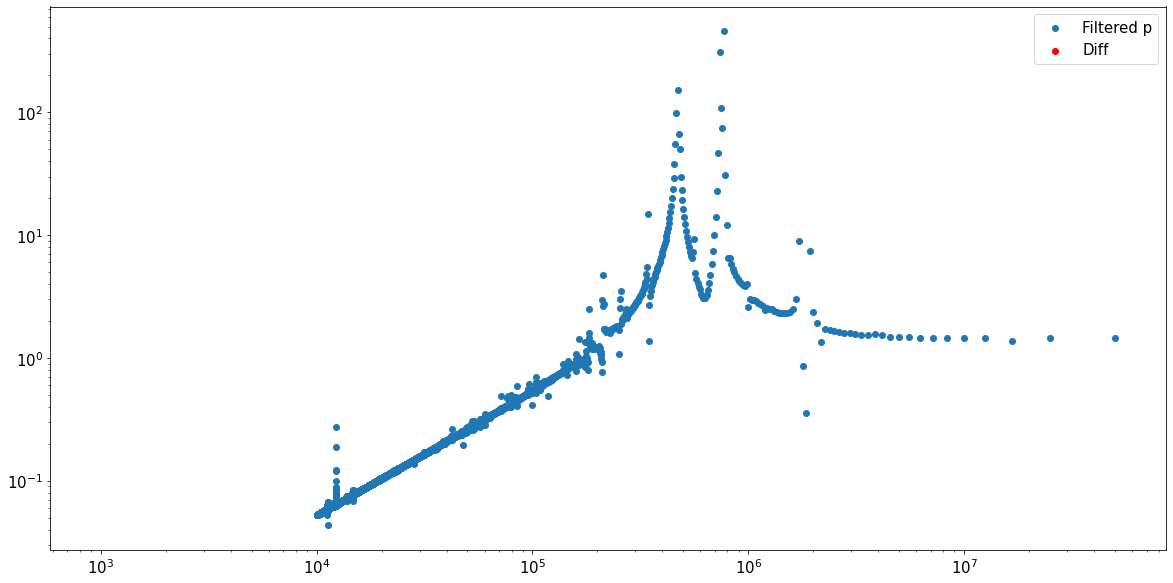

0
[]


/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


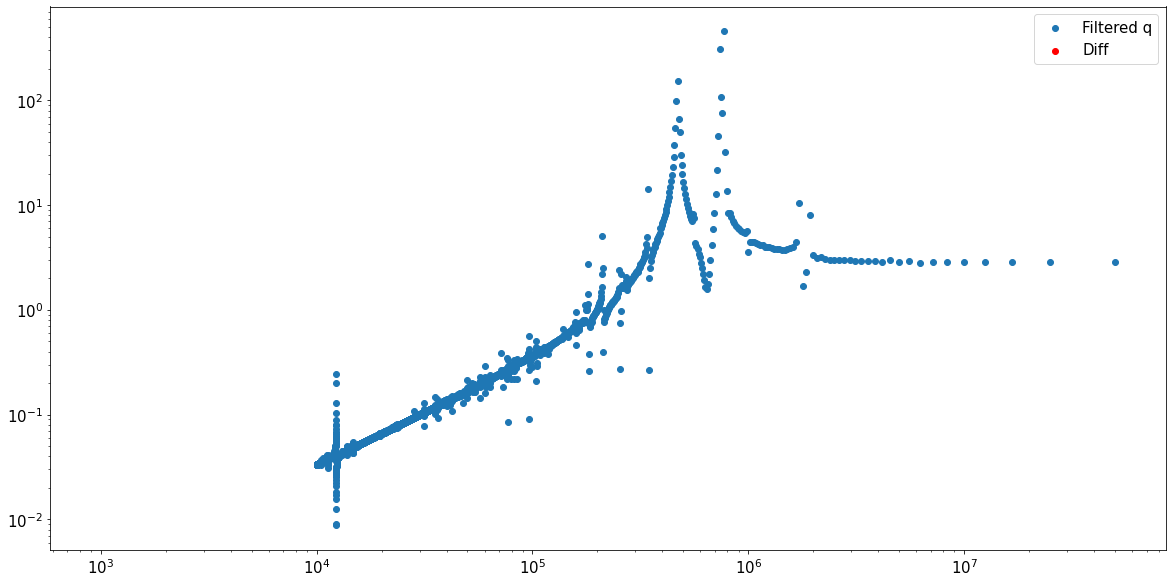

0.0 0.0
0.0
inf


/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [302]:
diffsp = np.abs(Yp_f)-Yp_1
diffindp = (np.where(diffsp != 0)[0])
print(len(diffindp))
print([diffindp])

plt.scatter(1/freq,np.abs(Yp_1),label='Filtered p')
plt.scatter(1/freq[diffindp],np.abs(Yp_1[diffindp]),label='Diff',c='r')
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.show()

diffsq = np.abs(Yq_f)-Yq_1
diffindq = (np.where(diffsq != 0)[0])
print(len(diffindq))
print(1/freq[diffindq])

plt.scatter(1/freq,np.abs(Yq_1),label='Filtered q')
plt.scatter(1/freq[diffindq],np.abs(Yq_1[diffindq]),label='Diff',c='r')
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.show()

print(Yp_1[0],np.abs(Yp_f[0]))
print(Yp_1[0]-np.abs(Yp_f[0]))
print(1/freq[0])

(1312.9196311804067+0j)
(208.64992793323617+0.00698153946982649j)
(130.9046635564327-1299.1086014206257j)
(1299.1020245063723+130.9024411852074j)
107 107 65 65


/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


50001
50001


/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


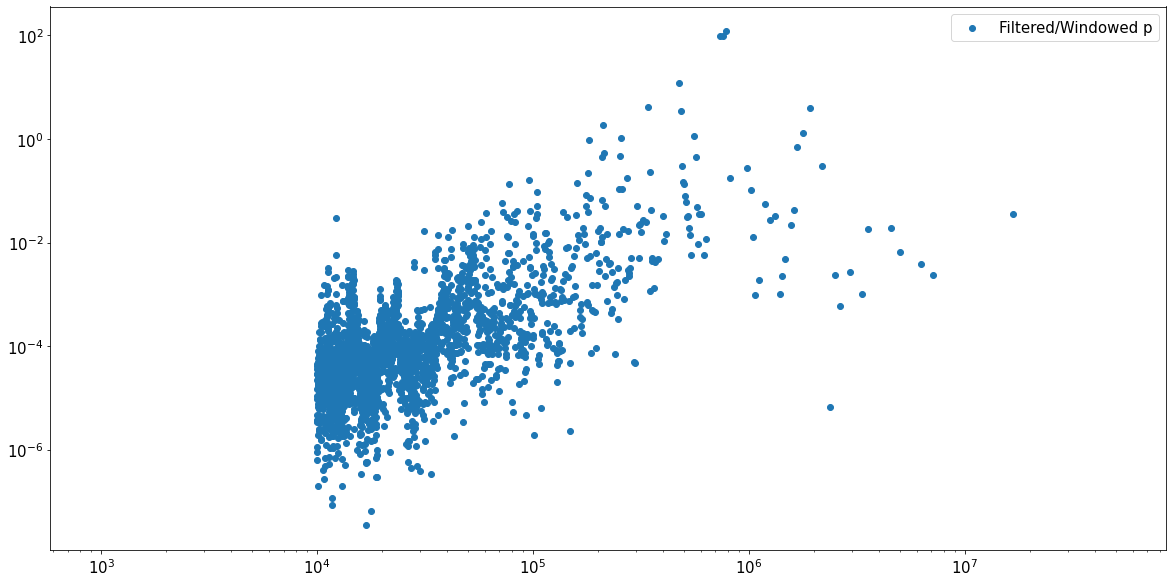

/home/byu.local/djspenc/.SBDynT/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide


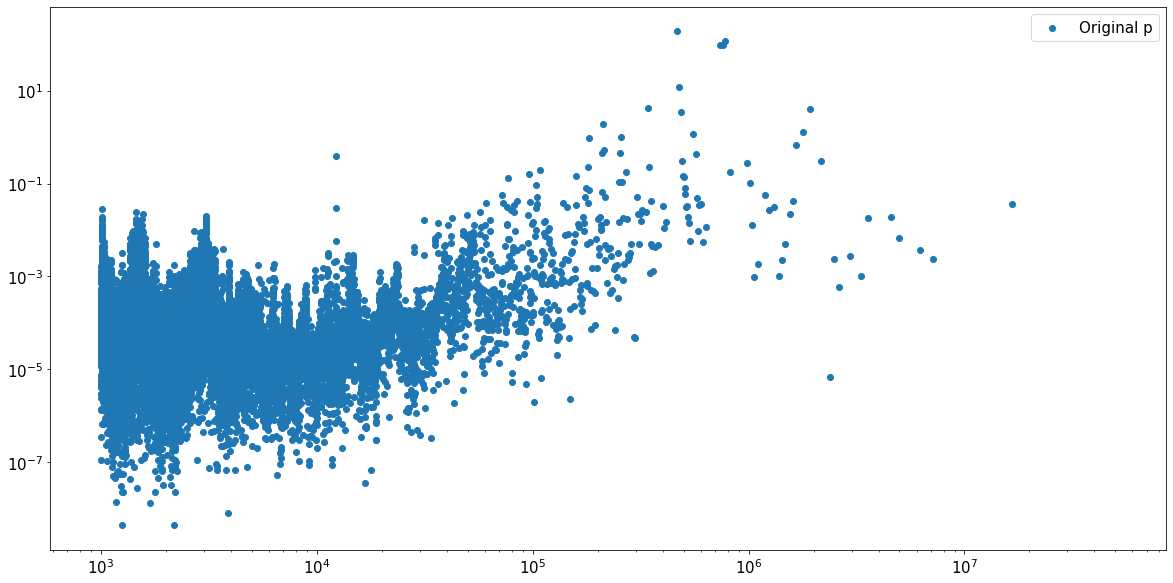

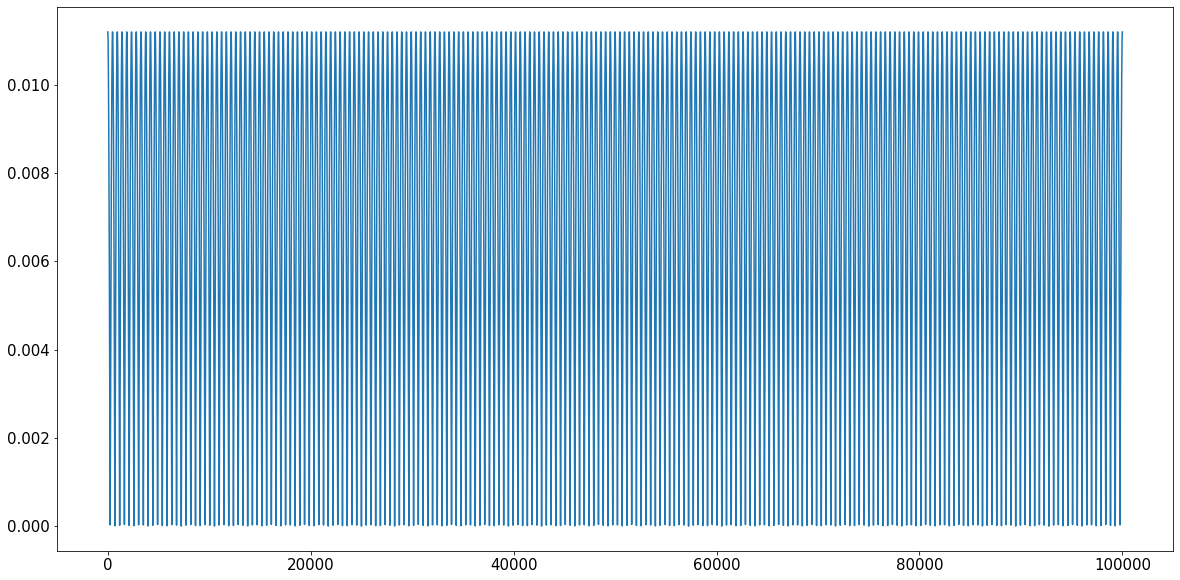

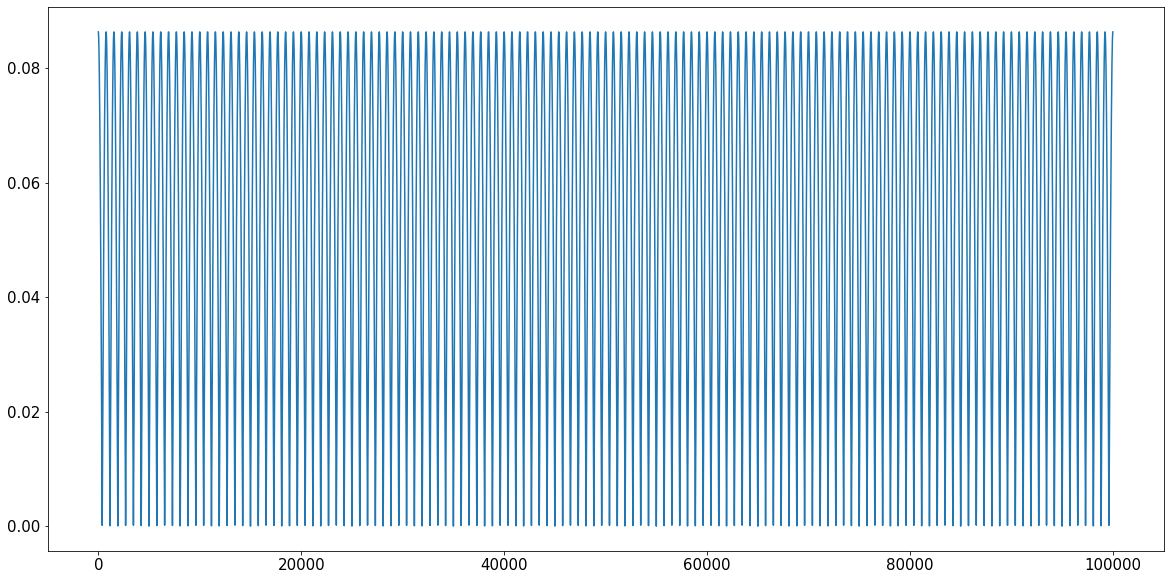

Calc: 0.006380856781657013
Single Freq: 0.011196756348018226
AstDys Sin(Inc): 0.011229
Calc: 0.044459585233179305
Single Freq: 0.08635779326434247
AstDys Ecc 0.0891079


In [323]:
#make copies of the FFT outputs
Yp_f = (np.fft.rfft(ph))
Yq_f = (np.fft.rfft(qh))
Yh_f = (np.fft.rfft(hh))
Yk_f = (np.fft.rfft(kh))

print(Yp_f.max())
print(Yq_f.max())
print(Yh_f.max())
print(Yk_f.max())

imax = len(Yp)
#disregard antyhing with a period shorter than 5000 years
freqlim = 1./10000.
#disregard frequencies for which any planet has power at higher than 10% the max
pth = 0.75

spread = 0
#'''
test = np.zeros(len(Yp_f))
test_2 = np.zeros(len(Yq_f))
test_3 = np.zeros(len(Yq_f)) 
test_4 = np.zeros(len(Yq_f))
if spread > 0:
    test[ipmax-spread:ipmax+spread] = Yp[ipmax-spread:ipmax+spread]
    test_2[iqmax-spread:iqmax+spread] = Yq[iqmax-spread:iqmax+spread]
    test_3[ihmax-spread:ihmax+spread] = Yh[ihmax-spread:ihmax+spread]
    test_4[ikmax-spread:ikmax+spread] = Yk[ikmax-spread:ikmax+spread]
else:
    test[ipmax] = Yp[ipmax]
    test_2[iqmax] = Yq[iqmax]
    test_3[ihmax] = Yh[ihmax]
    test_4[ikmax] = Yk[ikmax]

print(ipmax,iqmax,ihmax,ikmax)
for i in range(0,imax-1):
    if (pYunew[i]>pth*pumax or pYjnew[i]>pth*pjmax or pYsnew[i]>pth*psmax 
       or pYnnew[i]>pth*pnmax or freq[i]>freqlim):
        Yp_f[i]=0
    if (qYunew[i]>pth*qumax or qYnnew[i]>pth*qjmax or qYsnew[i]>pth*qsmax 
       or qYjnew[i]>pth*qnmax or freq[i]>freqlim):
        Yq_f[i]=0
    if (hYunew[i]>pth*humax or hYnnew[i]>pth*hjmax or hYjnew[i]>pth*hsmax 
       or hYsnew[i]>pth*hnmax or freq[i]>freqlim):
        Yh_f[i]=0
    if (kYunew[i]>pth*kumax or kYnnew[i]>pth*kjmax or kYjnew[i]>pth*ksmax 
       or kYsnew[i]>pth*knmax or freq[i]>freqlim):
        Yk_f[i]=0

p_f = np.fft.irfft(Yp_f,len(p))
q_f = np.fft.irfft(Yq_f,len(q))
h_f = np.fft.irfft(Yh_f,len(h))
k_f = np.fft.irfft(Yk_f,len(k))

i_p = np.fft.irfft(test,len(p))
i_q = np.fft.irfft(test_2,len(q))
i_h = np.fft.irfft(test_3,len(h))
i_k = np.fft.irfft(test_4,len(k))

print(len(Yp_f))
print(len(freq))

plt.scatter(1/freq,Yp_f,label='Filtered/Windowed p')
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.show()
#plt.scatter(freq,test)
plt.scatter(1/freq,(np.fft.rfft(ph)),label='Original p')
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.show()

#plt.scatter(freq,Yp_f)
#plt.scatter(freq,np.abs(np.fft.rfft(p)))
#plt.xscale('log')
#plt.yscale('log')
#plt.show()

#plt.scatter(t,p)
#plt.scatter(t,i_p)
#plt.scatter(t,p_f)
#plt.show()


sini = np.sqrt(ph*ph+qh*qh)
sini_f = np.sqrt(p_f*p_f + q_f*q_f)
ecc = np.sqrt(hh*hh+kh*kh)
ecc_f = np.sqrt(h_f*h_f + k_f*k_f)

sini_i = np.sqrt(i_p*i_p + i_q*i_q)
ecc_i = np.sqrt(i_h*i_h + i_k*i_k)

plt.plot(sini_i)
plt.show()
plt.plot(ecc_i)
plt.show()

print('Calc:',np.mean(sini_f))
print('Single Freq:',np.max(sini_i))
print('AstDys Sin(Inc):',0.0112290)
#print('AstDys 2004KF19', 0.0344540)
print('Calc:',np.mean(ecc_f))
print('Single Freq:',np.max(ecc_i))
print('AstDys Ecc', 0.0891079)
#print('AstDys 2004KF19:', 0.0578858)

# plot p,q
#note: not sure why there are stray dots not on the circle
plt.rcParams["figure.figsize"] = (10, 10)
plt.scatter(p,q,label='osculating');
plt.scatter(p_f,q_f,s=10,label='filtered');
plt.axhline(y=0,c='k');
plt.axvline(x=0,c='k');
plt.xlabel('p');
plt.xlabel('q');
plt.legend();


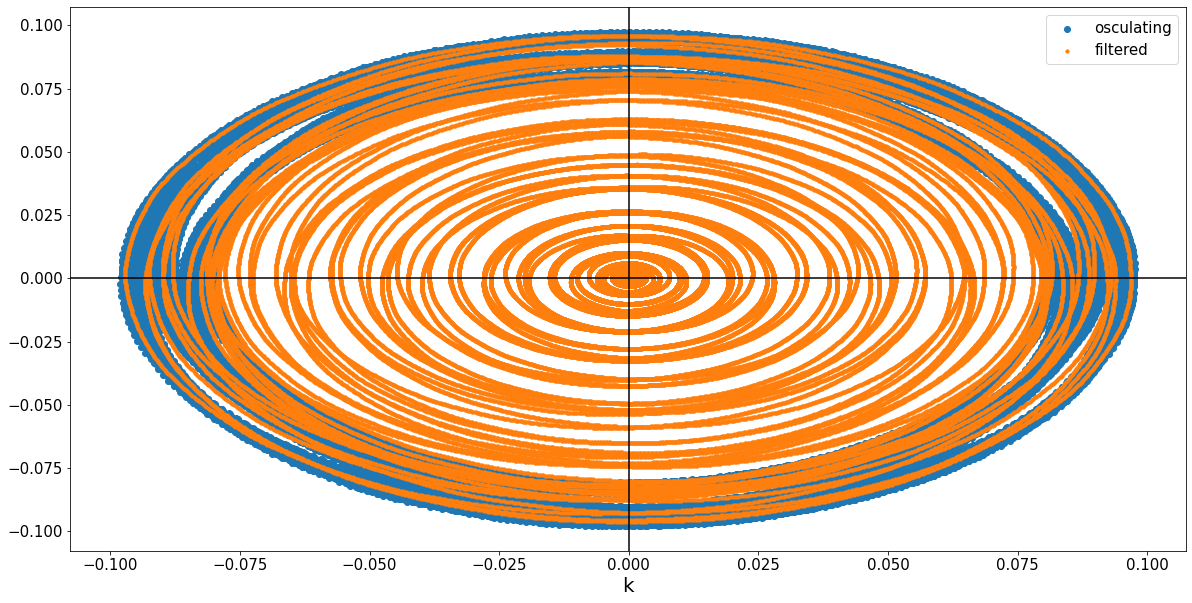

In [69]:
#plot h,k
#note: not sure why there are stray dots not on the circle
plt.scatter(h,k,label='osculating');
plt.scatter(h_f,k_f,s=10,label='filtered');
plt.axhline(y=0,c='k');
plt.axvline(x=0,c='k');
plt.xlabel('h');
plt.xlabel('k');
plt.legend();
plt.rcParams["figure.figsize"] = (20, 10)

the inclination filtering does get close-ish to the proper value, eccentricity one didn't do much of anything

In [ ]:
#plot oscuilating and filtered sini
plt.scatter(t,sini,s=5,label='osculating');
plt.scatter(t,sini_f,s=0.5,label='filtered');
#plot the range from Huang et al for this object
plt.axhline(y=np.sin(11.2669*np.pi/180),c='k',label='analytical proper sini range');
plt.axhline(y=np.sin(11.4669*np.pi/180),c='k');
plt.axhline(y=np.sin(11.0669*np.pi/180),c='k');
plt.xlabel('time(years)');
plt.ylabel('sin(i)');
plt.legend();

plt.xlim([0,t[-1]]);

In [ ]:
#plot oscuilating and filtered eccentrcicity
plt.scatter(t,ecc,s=5,label='osculating');
plt.scatter(t,ecc_f,s=0.5,label='filtered');

plt.xlabel('time(years)');
plt.ylabel('eccentricity');
plt.legend();

plt.xlim([0,t[-1]]);
plt.ylim([ecc.min()-0.01,ecc.max()+0.01]);

# below here are some random attempts with filters from the scipy signal package

In [ ]:
import scipy.signal
quality_factor = 3.
nmax = len(freq)
filt = freq[ipnmax]
print(1/freq[ipnmax])
fs = 1/500.

#Infinite Impulse Response Notch Filter
#Give the function a frequnecy to filter out and it will filter that specific frequency
b_f, a_f = signal.iirnotch(filt,quality_factor,fs=fs)

print(b_f, a_f)
alt_f_p = signal.filtfilt(b_f, a_f, p)
alt_f_q = signal.filtfilt(b_f, a_f, q)

tY = np.fft.rfft(alt_f_p)
ptY = np.abs(tY)

ffreq, fh = signal.freqz(b_f,a_f, fs=2.*np.pi,worN=nmax);

#Butterworth Bandstop Filter
#A digital filter that 
b, a = signal.butter(1, [freq[ipnmax-10],freq[ipnmax+10]], btype='bandstop',fs=fs)


#b_n, a_n = signal.butter(2, [freq[ipnmax-5],freq[ipnmax+25]], btype='bandstop')
print(b,a)
#alt_f_p2 = signal.filtfilt(b,a,p)
#alt_f_q2 = signal.filtfilt(b, a, q)

alt_f_p2 = signal.lfilter(b,a,p)
alt_f_q2 = signal.lfilter(b, a, q)

print(np.sum(alt_f_p2-p))

tY_2 = np.fft.rfft(alt_f_p2)
ptY2 = np.abs(tY_2)

ffreq2, fh2 = signal.freqz(b,a,fs=2*np.pi,worN=nmax)

plt.scatter(ffreq*fs/(2.*np.pi), np.abs(fh),
         c='r', label='Bandpass filter');

plt.scatter(freq, pYp,
         c='b', label='before filtering')
plt.scatter(freq, ptY,
         c='g', label='after filtering');

plt.legend();
 
plt.xlabel('Frequency [yr^{-1}]', fontsize=20);
plt.ylabel('Magnitude [dB]', fontsize=20);
plt.xscale('log');
plt.yscale('log');
plt.title('Notch Filter', fontsize=20);
plt.show()

#=================================================
plt.scatter(ffreq2*fs/(2.*np.pi), np.abs(fh2*fh),
         c='r', label='Bandpass filter');

plt.scatter(freq, pYp,
         c='b', label='before filtering')
plt.scatter(freq, ptY2,
         c='g', label='after filtering');

plt.legend();
 
plt.xlabel('Frequency [yr^{-1}]', fontsize=20);
plt.ylabel('Magnitude [dB]', fontsize=20);
plt.xscale('log');
plt.yscale('log');
plt.title('Butterworth Filter', fontsize=20);

plt.show()

In [ ]:
plt.scatter(np.arange(0,len(ptY)),np.fft.ifft(ptY)+0.8, s=0.5)
plt.scatter(np.arange(0,len(ptY2)),np.fft.ifft(ptY2)+0.4, s=0.5)
plt.scatter(np.arange(0,len(ptY2)),np.fft.ifft(pYp), s=0.5)
plt.show()

In [ ]:
alt_i_filtered = np.sqrt(alt_f_q*alt_f_q + alt_f_p*alt_f_p)
alt_i_filtered2 = np.sqrt(alt_f_q2*alt_f_q2 + alt_f_p2*alt_f_p2)
plt.figure()
plt.axes().set_aspect('equal')
plt.scatter(q,p)
plt.scatter(alt_f_q,alt_f_p,s=0.9)
plt.axhline(y=0)
plt.axvline(x=0)
plt.show()
print(alt_i_filtered)

Omega_new = np.arctan2(alt_f_p,alt_f_q)
inc_new = np.arcsin(alt_f_p/np.sin(Omega_new))

p_off = alt_f_p - np.mean(alt_f_p)
q_off = alt_f_q - np.mean(alt_f_q)

Omega_off = np.arctan2(p_off,q_off)
inc_off = np.arcsin(p_off/np.sin(Omega_off))
plt.plot(inc)
plt.plot(inc_new)
plt.plot(inc_off)
plt.show()

print(np.mean(inc_new))
print(np.mean(inc_off))
print('AstDys 2004KF19:',np.arcsin(0.0344540))

In [ ]:
plt.scatter(t,sini,s=5,label='osculating')
plt.scatter(t,alt_i_filtered,s=0.05,label='filtered')
#plt.axhline(y=np.sin(11.2669*np.pi/180))
#plt.axhline(y=np.sin(11.4669*np.pi/180))
#plt.axhline(y=np.sin(11.0669*np.pi/180))
plt.xlabel('time(years)')
plt.ylabel('sin(i)')
plt.legend()
plt.show()

plt.scatter(t,sini,s=5,label='osculating')
plt.scatter(t,alt_i_filtered2,s=0.05)
#plt.axhline(y=np.sin(11.2669*np.pi/180))
#plt.axhline(y=np.sin(11.4669*np.pi/180))
#plt.axhline(y=np.sin(11.0669*np.pi/180))
plt.xlabel('time(years)')
plt.ylabel('sin(i)')
plt.legend()
plt.show()


#plt.xlim([0,1e8])

In [ ]:
from scipy import signal

#plt.scatter(t,ecc)
plt.plot(Yp)
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
n = len(p)
freq2 = np.fft.fftfreq(n,d=dt)
b, a = signal.butter(1, 0.1, btype='highpass')
zi = signal.lfilter_zi(b, a)
print(len(p),len(freq2))
z, _ = signal.lfilter(b, a, p, zi=zi*p[0])
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
y = signal.filtfilt(b, a, p)
plt.figure()
plt.scatter(t, p, alpha=0.75)
#plt.scatter(t, z)
#plt.scatter(t, z2)
plt.scatter(t, y)
plt.show()
print(len(p),len(z))
plt.scatter(1/freq2, np.fft.fft(p), alpha=0.75)
#plt.scatter(1/freq2, np.fft.fft(z))
#plt.scatter(1/freq2, np.fft.fft(z2))
plt.scatter(1/freq2, np.fft.fft(y))
plt.yscale('log')
plt.xscale('log')
plt.show()

1.3000000000000001e-05 1.32e-05 1.35e-05
50001 50001


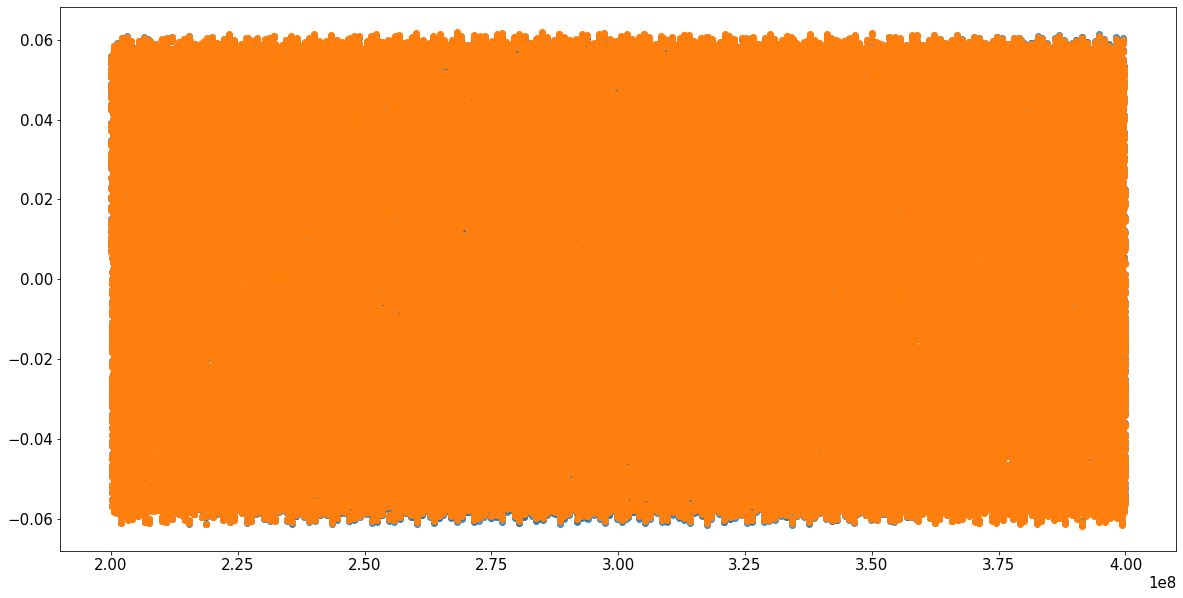

[ 0.02283639  0.02004361  0.01782442 ... -0.00824397 -0.00354802
  0.00097215]
100000 50001


NameError: name 'freq2' is not defined

In [20]:

print(freq[ihjmax-5], freq[ihjmax+5],freq[ihjmax+20])
b, a = signal.butter(1, [freq[ihjmax-5],freq[ihjmax+5]], btype='bandstop')
zi = signal.lfilter_zi(b, a)
print(len(pYp),len(freq))
z, _ = signal.lfilter(b, a, hj, zi=zi*hj[0])
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
y = signal.filtfilt(b, a, hj)
plt.figure()
plt.scatter(t, hj, alpha=0.75)
#plt.scatter(t, z)
#plt.scatter(t, z2)
plt.scatter(t, y)
#plt.yscale('log')
#plt.xscale('log')
plt.show()

print(y)

print(len(hj),len(freq))
new = np.fft.fft(y)
plt.scatter(1/freq2,np.fft.fft(hj))
plt.scatter(1/freq2,new)
plt.vlines(1/freq[ihjmax],ymin=1e-3,ymax=1e3)
plt.xscale('log')
plt.yscale('log')

In [ ]:
from scipy.signal import peak_widths,find_peaks
print(ihjmax, freq[ihjmax],1/freq[ihjmax])
peaks, _ = find_peaks(pYpj)
plt.plot(freq[1:],pYhj[1:])
plt.vlines(freq[ihjmax],ymin=1e-3,ymax=1e3)
results_full = peak_widths(pYpj, peaks, rel_height=5)
print(np.array(results_full))
#plt.hlines(*results_full[1:], color="C3")
plt.yscale('log')
plt.xscale('log')

In [ ]:
print(str(3).zfill(3))